# Kaggle_Bike_Sharing_Demand_version_1.0

## 프로젝트 목적
*  날짜와 시간에 따른 자전거 대여수를 예측

### 데이터 다운로드

https://www.kaggle.com/c/bike-sharing-demand/data

### 1. 데이터 소개
- 2011년1월부터 2012년12월까지 매시간 마다 날짜 및 시간, 기온, 습도, 풍속 등의 정보를 기반으로 1시간 간격의 자전거 대여 횟수를 기록한 데이터이다.


#### 1.1 데이터 딕셔너리
- datetime - hourly date + timestamp (날짜와 시간)
- season - 1 = spring, 2 = summer, 3 = fall, 4 = winter (계절)
- holiday - whether the day is considered a holiday (휴일)
- workingday - whether the day is neither a weekend nor holiday (평일)
- weather
    - 1 : Clear, Few clouds, Partly cloudy, Partly cloudy (맑은 날씨)
    - 2 : Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist (안개)
    - 3 : Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds (가벼운 눈, 비)
    - 4 : Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog (폭설, 폭우)
- temp - temperature in Celsius (온도)
- atemp - “feels like” temperature in Celsius (체감 온도)
- humidity - relative humidity (상대 습도)
- windspeed - wind speed (풍속)
- casual - number of non-registered user rentals initiated (비회원 대여량)
- registered - number of registered user rentals initiated (회원 대여량)
- count - number of total rentals (총 대여량)

#### 1.2 평가방식 : RMSLE
- RMSLE 평가 방식은 과대평가 된 항목보다는 과소평가 된 항목에 페널티를 준다. 오차(Error)를 제곱(Square)해서 평균(Mean)한 값의 제곱근(Root)으로 값이 작을수록 정밀도가 높다. 0에 가까운 값이 나올수록 정밀도가 높은 값이다.

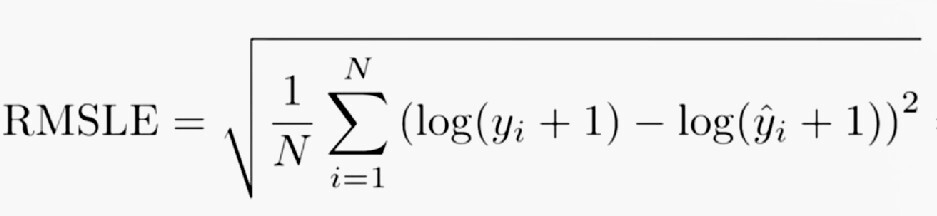

In [85]:
from IPython.display import Image
Image("./RMSLE평가.jpeg")

* 평가 함수 생성

In [6]:
# score 제작 준비
from sklearn.metrics import make_scorer
 
# RMSLE 함수 정의
def RMSLE(predicted_values, actual_values) :
    # 예측값과 실제 값을 numpy 배열 형태로 변환
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 로그 변환 
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 로그 변환한 예측값에서 로그 변환한 실제 값을 빼고 제곱
    difference = log_predict - log_actual
    
    difference = np.square(difference)
    difference = np.array(difference)
    
    # 위에서 계산한 값의 평균
    mean_difference = difference.mean()
    # 위에서 계산한 값에 루트
    score = np.sqrt(mean_difference)
    
    return score
 
rmsle_score = make_scorer(RMSLE)

### 2. 탐색적 데이터 분석(EDA)
    - 시각화 자료를 만들거나 기술 통계값 조회, 결측치나 이상치 등을 확인하고 데이터에 대해 알아가는 단계이다.
    

#### 2.1 분석에 필요한 패키지 가져오기

In [87]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')


import warnings
warnings.filterwarnings("ignore")

mpl.rcParams['axes.unicode_minus'] = False

#### 2.2 데이터 셋 확인

In [339]:
train = pd.read_csv("./bike-sharing-demand/train.csv", parse_dates=["datetime"])
display(train)
test = pd.read_csv("./bike-sharing-demand/test.csv", parse_dates=["datetime"])
display(test)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014
...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981


* train 데이터에는 casual,registered 컬럼 데이터가 존재하지만 test 데이터에는 존재하지 않는 것을 확인
    - train 데이터에서 casual, registered 컬럼을 삭제

In [340]:
train.drop(columns=['casual','registered'],inplace = True)
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1


#### 2.3 데이터 타입 확인

In [327]:
display(train.info())
display(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(6)
memory usage: 850.6 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    6493 non-null   datetime64[ns]
 1   season      6493 non-null   int64         
 2   holiday     6493 non-null   int64         
 3   workingday  6493 non-null   int64         
 4   weather     6493 non-null   int64         
 5   temp        6493 non-null   float64       
 6   atemp       6493 non-null   float64       
 7   humidity    6493 non-null   int64         
 8   windspeed   6493 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 456.7 KB


None

#### 2.4 데이터 결측치 확인


In [328]:
print(train.isnull().sum())
print(test.isnull().sum())

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
count         0
dtype: int64
datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64


#### 2.5 통계값 확인

In [329]:
display(train.describe())
display(test.describe())

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,977.000000


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


#### 2.6 데이터 전처리

##### 2.6.1 datetime을 년,월,일,시,분,초,요일 값으로 나누어서 컬럼에 추가

In [341]:
train['year'] = train.datetime.dt.year
train['month'] = train.datetime.dt.month
train['day'] = train.datetime.dt.day
train['hour'] = train.datetime.dt.hour
train['minute'] = train.datetime.dt.minute
train['second'] = train.datetime.dt.second
train['dayofweek'] = train.datetime.dt.dayofweek # 요일

test['year'] = test.datetime.dt.year
test['month'] = test.datetime.dt.month
test['day'] = test.datetime.dt.day
test['hour'] = test.datetime.dt.hour
test['minute'] = test.datetime.dt.minute
test['second'] = test.datetime.dt.second
test['dayofweek'] = test.datetime.dt.dayofweek

display(train.head())
display(test.head())
print(train.shape,test.shape)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,minute,second,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0,0,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1,0,0,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2,0,0,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,1,3,0,0,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,1,4,0,0,5


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,minute,second,dayofweek
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0,0,0,3
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1,0,0,3
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2,0,0,3
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,0,0,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4,0,0,3


(10886, 17) (6493, 16)


In [342]:
# datetile 을 쪼개서 컬렘에 추가했기 때문에 datetime 컬럼은 필요 없어짐
train.drop(columns=['datetime'],inplace = True)
test.drop(columns=['datetime'],inplace = True)
display(train.head())
display(test.head())

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,minute,second,dayofweek
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0,0,0,5
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1,0,0,5
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2,0,0,5
3,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,1,3,0,0,5
4,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,1,4,0,0,5


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,minute,second,dayofweek
0,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0,0,0,3
1,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1,0,0,3
2,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2,0,0,3
3,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,0,0,3
4,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4,0,0,3


##### 2.6.2 시간 값에 따른 count 값의 변화량 확인

[Text(0, 0.5, 'count'), Text(0.5, 1.0, 'Rental amount by dayofweek')]

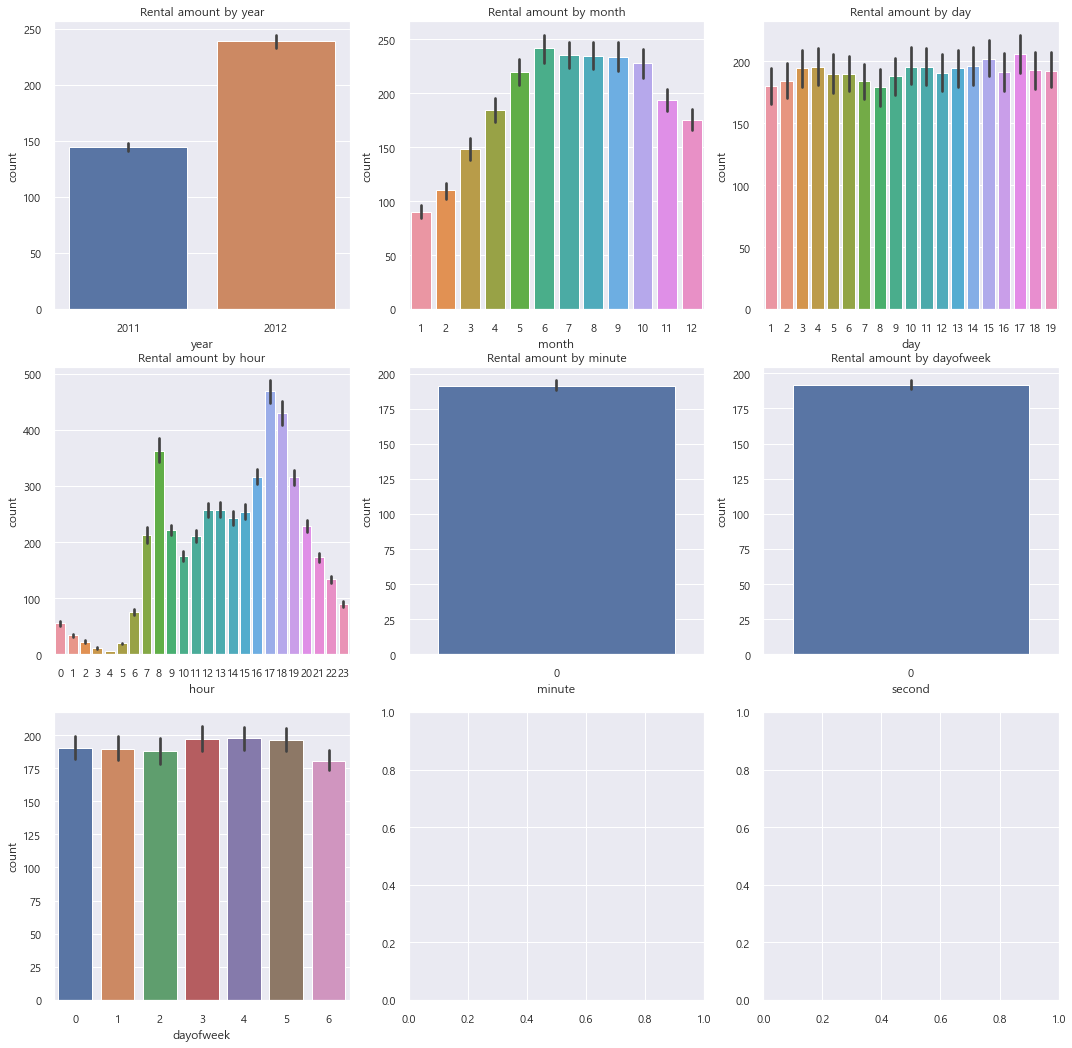

In [343]:
# 한글 깨짐 방지 코드
sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')


figure, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(nrows=3,ncols=3)
figure.set_size_inches(18,18)

sns.barplot(data=train,x='year',y='count',ax=ax1)
sns.barplot(data=train,x='month',y='count',ax=ax2)
sns.barplot(data=train,x='day',y='count',ax=ax3)
sns.barplot(data=train,x='hour',y='count',ax=ax4)
sns.barplot(data=train,x='minute',y='count',ax=ax5)
sns.barplot(data=train,x='second',y='count',ax=ax6)
sns.barplot(data=train,x='dayofweek',y='count',ax=ax7)


ax1.set(ylabel = "count", title = "Rental amount by year")
ax2.set(ylabel = "count", title = "Rental amount by month")
ax3.set(ylabel = "count", title = "Rental amount by day")
ax4.set(ylabel = "count", title = "Rental amount by hour")
ax5.set(ylabel = "count", title = "Rental amount by minute")
ax6.set(ylabel = "count", title = "Rental amount by second")
ax6.set(ylabel = "count", title = "Rental amount by dayofweek")

* day 컬럼의 경우 20 ~ 31일 까지의 데이터가 존재하지 않는 것을 확인
* minute,second 컬럼은 데이터가 존재 하지 않는 것을 확인

    -> day,minute,second 컬럼을 삭제

In [344]:
train.drop(columns=['day','minute','second'],inplace = True)
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,hour,dayofweek
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,0,5
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,5
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,2,5
3,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,3,5
4,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,4,5


#### 2.7 데이터 시각화

##### 2.7.1 각각의 feature 값들의 빈도수 분포도 확인

<AxesSubplot:xlabel='count', ylabel='Count'>

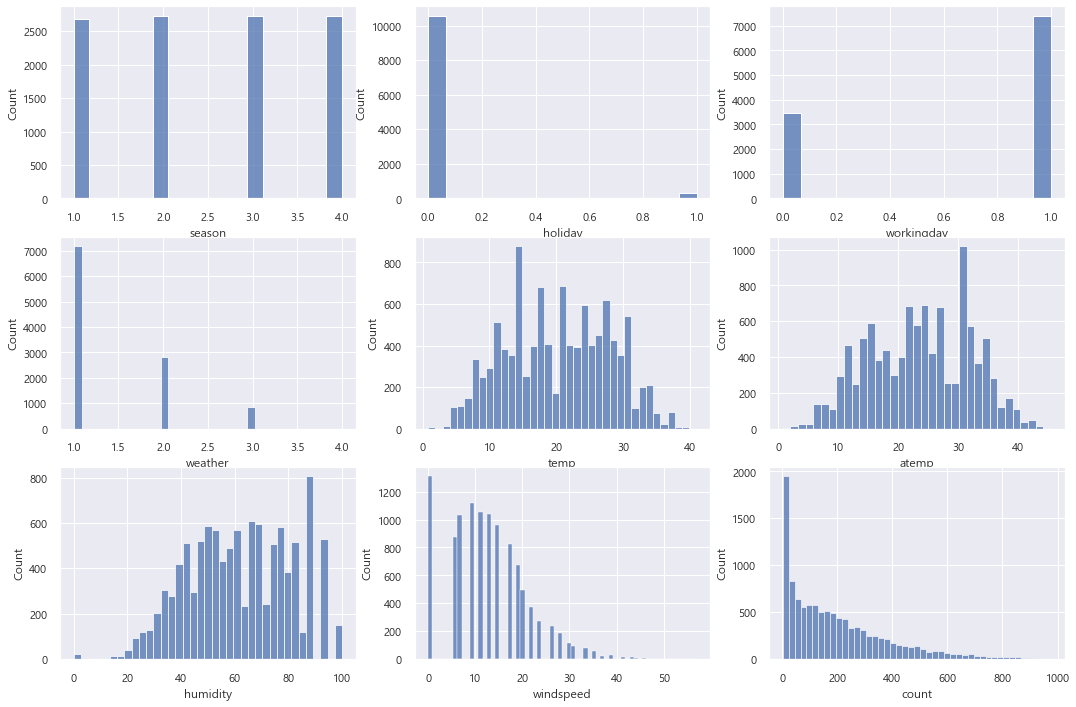

In [96]:
figure,ax= plt.subplots(nrows=3,ncols=3)
figure.set_size_inches(18,12)

sns.histplot(train['season'],ax=ax[0][0])
sns.histplot(train['holiday'],ax=ax[0][1])
sns.histplot(train['workingday'],ax=ax[0][2])
sns.histplot(train['weather'],ax=ax[1][0])
sns.histplot(train['temp'],ax=ax[1][1])
sns.histplot(train['atemp'],ax=ax[1][2])
sns.histplot(train['humidity'],ax=ax[2][0])
sns.histplot(train['windspeed'],ax=ax[2][1])
sns.histplot(train['count'],ax=ax[2][2])

* windspeed 분도중 0 인 값이 가장 많다.

##### 2.7.2 기상정보에 대한 대여량의 산점도를 확인

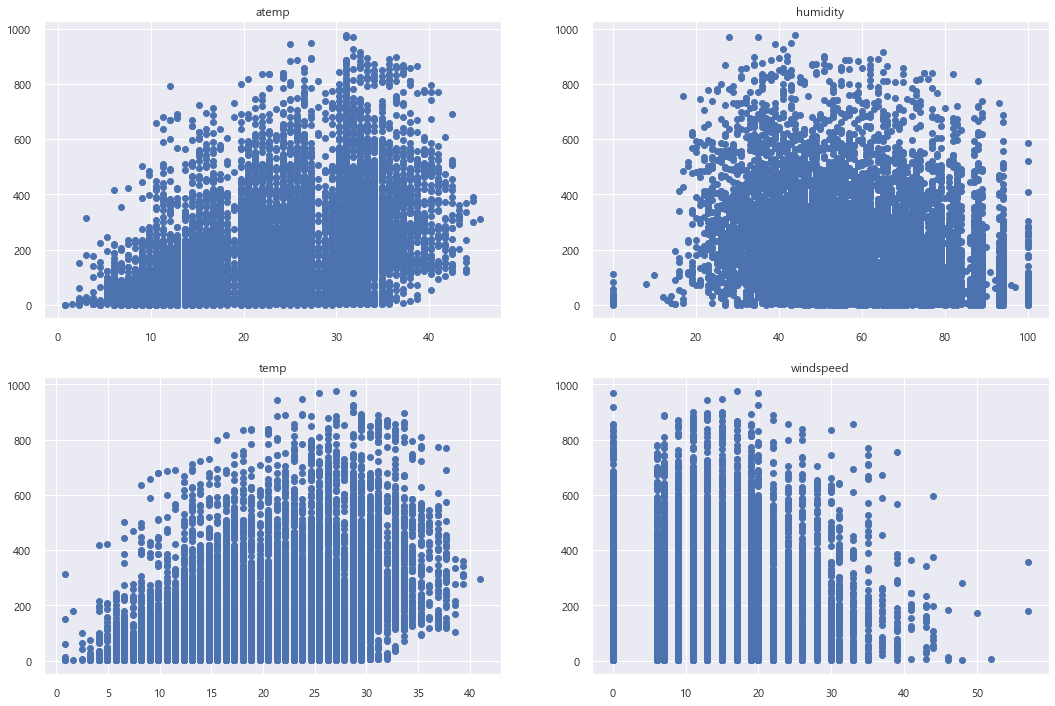

In [97]:
fig, ax = plt.subplots(2, 2, figsize=(18,12))
 
# scatter plot
ax[0][0].scatter(train['atemp'], train['count'])
ax[0][1].scatter(train['humidity'], train['count'])
ax[1][0].scatter(train['temp'], train['count'])
ax[1][1].scatter(train['windspeed'], train['count'])
 
# title 지정
ax[0][0].set(title='atemp')
ax[0][1].set(title='humidity')
ax[1][0].set(title='temp')
ax[1][1].set(title='windspeed')
 
plt.show()

##### 2.6.3 각각의 features 들의 상관관계

<AxesSubplot:>

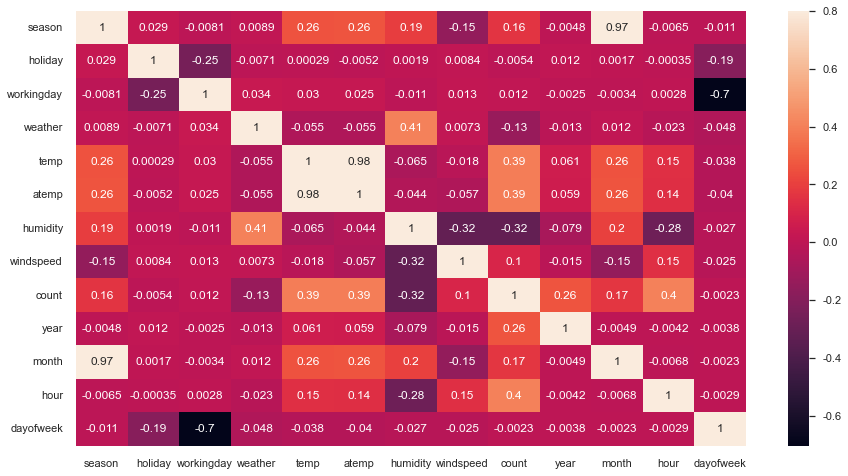

In [98]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(train.corr(),annot=True,vmax=.8)

* temp, atemp 컬럼의 상관 관계가 0.98로 강한 상관관계를 가지고 있다.
* month, season 컬럼의 상관 관계가 0.97로 강한 상관관계를 가지고 있다. 

##### 2.6.4 시간별 요인에 따른 count 값 변화량 확인

<AxesSubplot:xlabel='hour', ylabel='count'>

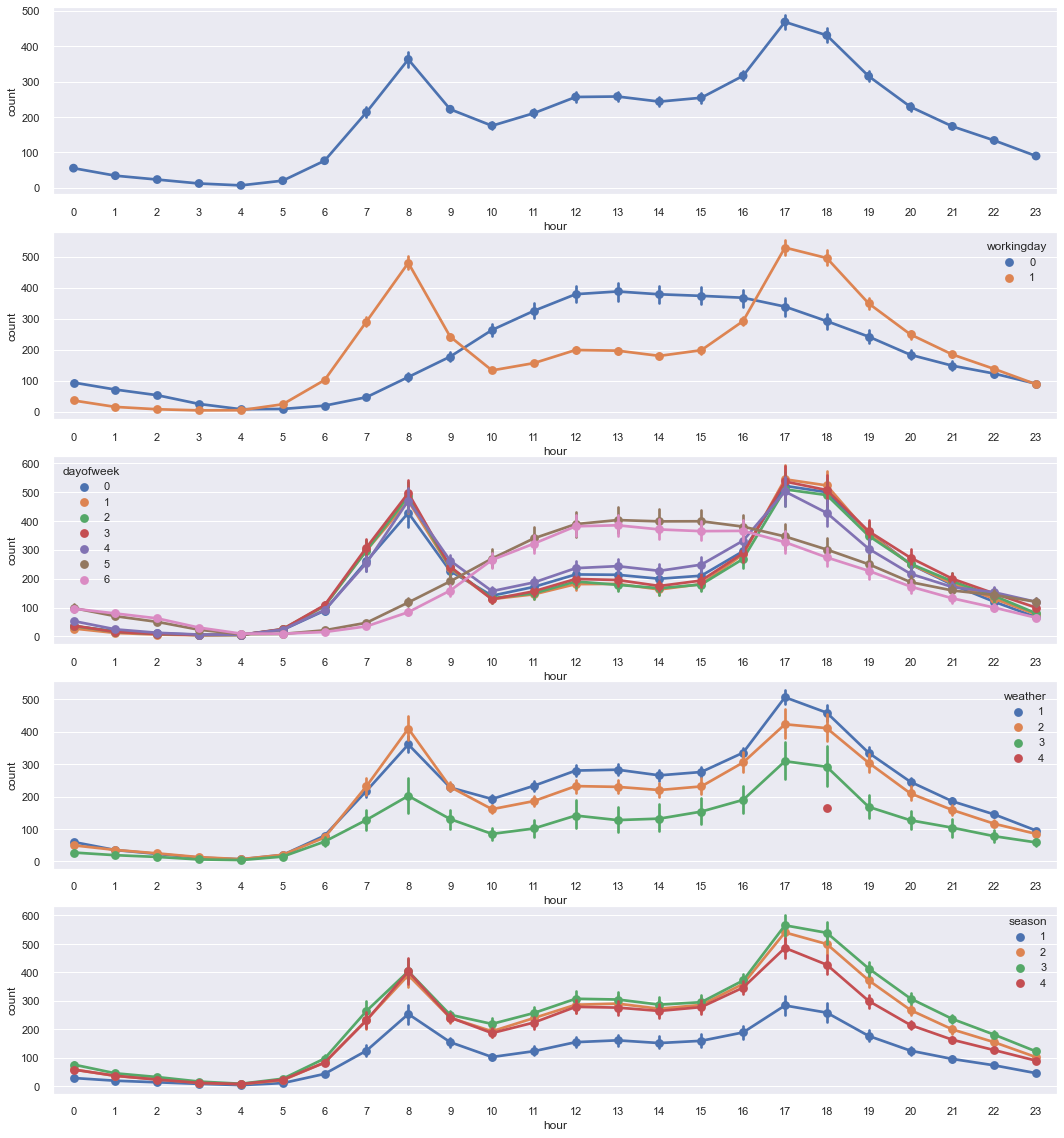

In [99]:
fig, (ax1, ax2, ax3, ax4, ax5)=plt.subplots(nrows=5)
fig.set_size_inches(18,20)

sns.pointplot(data=train, x="hour", y="count", ax=ax1)
# x, y, hue names of variables in data or vector data, optional
sns.pointplot(data=train, x="hour", y="count",hue='workingday' ,ax=ax2)
sns.pointplot(data=train, x="hour", y="count",hue='dayofweek' ,ax=ax3)
sns.pointplot(data=train, x="hour", y="count",hue='weather' ,ax=ax4)
sns.pointplot(data=train, x="hour", y="count",hue='season' ,ax=ax5)

### 3. 특성공학(Feature Engineering)

#### 3.1 Train 데이터에 사용할 특성들 선택

In [336]:
features = ["season", "weather", "temp", "atemp", "humidity", "windspeed",'month',
            "year", "hour", "dayofweek", "holiday", "workingday"]
features

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'month',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

#### 3.2 Train 과 test에서 원하는 특성들만 추출

In [110]:
X_train = train[features]
X_test = test[features] 
display(X_train)
display(X_test)

,season,weather,temp,atemp,humidity,windspeed,month,year,hour,dayofweek,holiday,workingday
0,1,1,9.84,14.395,81,0.0000,1,2011,0,5,0,0
1,1,1,9.02,13.635,80,0.0000,1,2011,1,5,0,0
2,1,1,9.02,13.635,80,0.0000,1,2011,2,5,0,0
3,1,1,9.84,14.395,75,0.0000,1,2011,3,5,0,0
4,1,1,9.84,14.395,75,0.0000,1,2011,4,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,1,15.58,19.695,50,26.0027,12,2012,19,2,0,1
10882,4,1,14.76,17.425,57,15.0013,12,2012,20,2,0,1
10883,4,1,13.94,15.910,61,15.0013,12,2012,21,2,0,1
10884,4,1,13.94,17.425,61,6.0032,12,2012,22,2,0,1


,season,weather,temp,atemp,humidity,windspeed,month,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,1,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,1,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,1,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,1,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,1,2011,4,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6488,1,2,10.66,12.880,60,11.0014,12,2012,19,0,0,1
6489,1,2,10.66,12.880,60,11.0014,12,2012,20,0,0,1
6490,1,1,10.66,12.880,60,11.0014,12,2012,21,0,0,1
6491,1,1,10.66,13.635,56,8.9981,12,2012,22,0,0,1


#### 3.3 예측해야할 count 특성 추출

In [112]:
y_train = train['count']
y_train

0         16
1         40
2         32
3         13
4          1
        ... 
10881    336
10882    241
10883    168
10884    129
10885     88
Name: count, Length: 10886, dtype: int64

#### 3.4 데이터 형 변환
    - 카테고리 형 컬럼 처리 방식
        - category 형 변환 vs One-Hot-Encoding
    - 카테고리 형 데이터 컬럼 : "season", "holiday", "workingday", "weather","year","month","day","hour"

In [128]:
category_features = ["season", "holiday", "workingday", "weather",'year','month','hour','dayofweek'] #as type으로 category 형변환 
for i in category_features :
    X_train[i] = X_train[i].astype("category")
    X_test[i] = X_test[i].astype("category")

In [129]:
display(X_train.info())
display(X_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      10886 non-null  category
 1   weather     10886 non-null  category
 2   temp        10886 non-null  float64 
 3   atemp       10886 non-null  float64 
 4   humidity    10886 non-null  int64   
 5   windspeed   10886 non-null  float64 
 6   month       10886 non-null  category
 7   year        10886 non-null  category
 8   hour        10886 non-null  category
 9   dayofweek   10886 non-null  category
 10  holiday     10886 non-null  category
 11  workingday  10886 non-null  category
dtypes: category(8), float64(3), int64(1)
memory usage: 427.6 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      6493 non-null   category
 1   weather     6493 non-null   category
 2   temp        6493 non-null   float64 
 3   atemp       6493 non-null   float64 
 4   humidity    6493 non-null   int64   
 5   windspeed   6493 non-null   float64 
 6   month       6493 non-null   category
 7   year        6493 non-null   category
 8   hour        6493 non-null   category
 9   dayofweek   6493 non-null   category
 10  holiday     6493 non-null   category
 11  workingday  6493 non-null   category
dtypes: category(8), float64(3), int64(1)
memory usage: 256.0 KB


None

#### 3.5 예측해야 하는 count 값에 이상치가 있는 지 확인

<AxesSubplot:xlabel='count', ylabel='Count'>

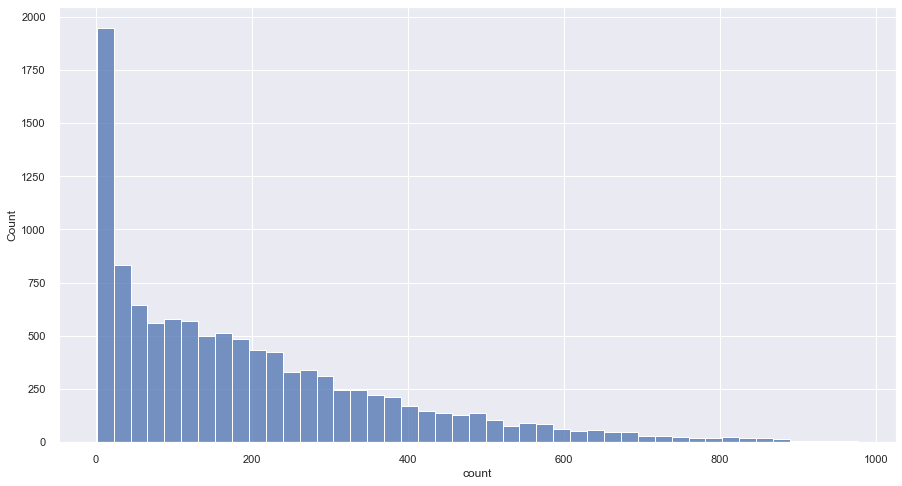

In [240]:
fig.set_size_inches(12, 5)
sns.histplot(train['count'])

* count 컬럼의 값의 분포도를 확인 결과 0 데이터가 높은 것을 파악
* 더욱 나은 예측을 위해서는 정규분포 형식을 따르는 것이 좋으므로 값을 log 값으로 변형시켜야 한다.

<AxesSubplot:ylabel='Density'>

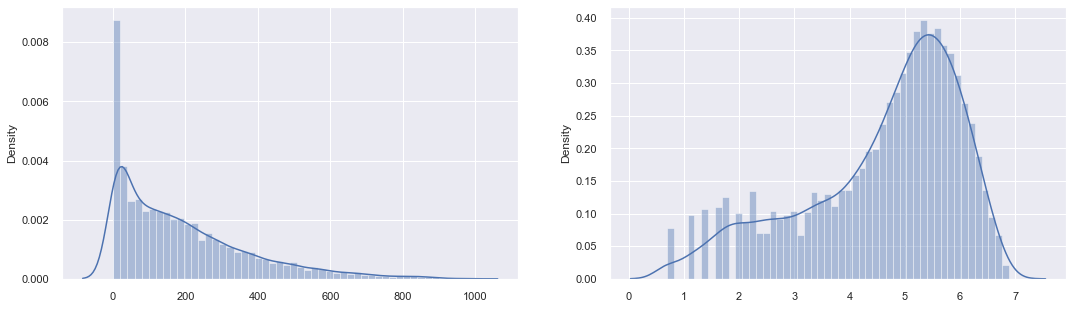

In [246]:
y_train_log = np.log1p(y_train)

fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(18,5)
sns.distplot(y_train,bins=50,ax=ax1)
sns.distplot(y_train_log,bins=50,ax=ax2)

### 4. 모델링

#### 4.1 LinearRegression

In [247]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# 테스트 데이터 80, 검증 데이터 20으로 분리
train_input,test_input,train_target,test_target = train_test_split(X_train,y_train_log,random_state=42)


lr = LinearRegression()

# 교차 검증
kfold = KFold(n_splits=10, random_state=1000, shuffle=True)
cross_score = cross_val_score(lr, X_train, y_train_log, cv=kfold, scoring=rmsle_score)
print("cross_val_score :",cross_score.mean())

lr.fit(train_input,train_target)
print('LinearRegression train score : ',lr.score(train_input,train_target))
print('LinearRegression test score : ',lr.score(test_input,test_target))

pred_train = lr.predict(train_input)
print('RMSLE LinearRegression train score : ',RMSLE(np.exp(pred_train),np.exp(train_target)))
pred_test = lr.predict(test_input)
print('RMSLE LinearRegression test score : ',RMSLE(np.exp(pred_test),np.exp(test_target)))

lr.fit(X_train,y_train_log)
final_pred = lr.predict(X_test)
# 결과 
submission = pd.read_csv('./bike-sharing-demand/sampleSubmission.csv')
submission['count'] = np.exp(final_pred)
submission.to_csv('LinearRegression'+' {0:.5f}.csv'.format(RMSLE(np.exp(pred_test),np.exp(test_target))), index=False)
submission.head(10)

cross_val_score : 0.23129601643301254
LinearRegression train score :  0.490008606903534
LinearRegression test score :  0.48028769192244036
RMSLE LinearRegression train score :  0.9766946111571329
RMSLE LinearRegression test score :  0.9824488498198681


,datetime,count
0,2011-01-20 00:00:00,12.747805
1,2011-01-20 01:00:00,13.449495
2,2011-01-20 02:00:00,14.836042
3,2011-01-20 03:00:00,16.805624
4,2011-01-20 04:00:00,18.538166
5,2011-01-20 05:00:00,18.522542
6,2011-01-20 06:00:00,19.771469
7,2011-01-20 07:00:00,23.442238
8,2011-01-20 08:00:00,26.379501
9,2011-01-20 09:00:00,30.644402


* LinearRegression - kaggle 제출 결과 : 1.04992 - 1000등 이상 

#### 4.2 Ridge

In [251]:
# 릿지 회귀
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


train_input,test_input,train_target,test_target = train_test_split(X_train,y_train_log,random_state=42)

ridge = Ridge()


# 교차 검증
kfold = KFold(n_splits=10, random_state=1000, shuffle=True)
cross_score = cross_val_score(ridge, X_train, y_train_log, cv=kfold, scoring=rmsle_score)
print("cross_val_score :",cross_score.mean())

ridge.fit(train_input,train_target)
print('Ridge train score : ',ridge.score(train_input,train_target))
print('Ridge test score : ',ridge.score(test_input,test_target))

pred_train = ridge.predict(train_input)
print('RMSLE Ridge train score : ',RMSLE(np.exp(pred_train),np.exp(train_target)))
pred_test = ridge.predict(test_input)
print('RMSLE Ridge test score : ',RMSLE(np.exp(pred_test),np.exp(test_target)))

ridge.fit(X_train,y_train)
final_pred = ridge.predict(X_test)
# 결과 
submission = pd.read_csv('./bike-sharing-demand/sampleSubmission.csv')
submission['count'] = np.exp(final_pred)
submission.to_csv('Ridge'+' {0:.5f}.csv'.format(RMSLE(np.exp(pred_test),np.exp(test_target))), index=False)
submission.head(10)

cross_val_score : 0.23129610385124194
Ridge train score :  0.4900085995442265
Ridge test score :  0.4802881640803506
RMSLE Ridge train score :  0.9766943724472094
RMSLE Ridge test score :  0.9824482798784074


,datetime,count
0,2011-01-20 00:00:00,5.687691e-15
1,2011-01-20 01:00:00,5.778084e-14
2,2011-01-20 02:00:00,1.379553e-10
3,2011-01-20 03:00:00,8.774850e-06
4,2011-01-20 04:00:00,2.095050e-02
5,2011-01-20 05:00:00,3.701481e-05
6,2011-01-20 06:00:00,6.554316e-04
7,2011-01-20 07:00:00,4.060355e+04
8,2011-01-20 08:00:00,1.172899e+09
9,2011-01-20 09:00:00,1.045110e+14


* Ridge - kaggle 제출 결과 : 1.04988

#### 4.3 Lasso

In [252]:
# Lasso 회귀
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


train_input,test_input,train_target,test_target = train_test_split(X_train,y_train_log,random_state=42)

lasso = Lasso()


# 교차 검증
kfold = KFold(n_splits=10, random_state=1000, shuffle=True)
cross_score = cross_val_score(ridge, X_train, y_train_log, cv=kfold, scoring=rmsle_score)
print("cross_val_score :",cross_score.mean())

lasso.fit(train_input,train_target)
print('Lasso train score : ',lasso.score(train_input,train_target))
print('Lasso test score : ',lasso.score(test_input,test_target))

pred_train = lasso.predict(train_input)
print('RMSLE Lasso train score : ',RMSLE(np.exp(pred_train),np.exp(train_target)))
pred_test = lasso.predict(test_input)
print('RMSLE Lasso test score : ',RMSLE(np.exp(pred_test),np.exp(test_target)))

lasso.fit(X_train,y_train_log)
final_pred = lasso.predict(X_test)
# 결과 
submission = pd.read_csv('./bike-sharing-demand/sampleSubmission.csv')
submission['count'] = np.exp(final_pred)
submission.to_csv('Lasso'+' {0:.5f}.csv'.format(RMSLE(np.exp(pred_test),np.exp(test_target))), index=False)
submission.head(10)

cross_val_score : 0.23129610385124194
Lasso train score :  0.43107563983081254
Lasso test score :  0.424965864676329
RMSLE Lasso train score :  1.0293330380001369
RMSLE Lasso test score :  1.031090807095602


,datetime,count
0,2011-01-20 00:00:00,26.706789
1,2011-01-20 01:00:00,31.520843
2,2011-01-20 02:00:00,34.127682
3,2011-01-20 03:00:00,35.904939
4,2011-01-20 04:00:00,38.874351
5,2011-01-20 05:00:00,37.690010
6,2011-01-20 06:00:00,39.645247
7,2011-01-20 07:00:00,45.853804
8,2011-01-20 08:00:00,49.646007
9,2011-01-20 09:00:00,57.562882


* Lasso - kaggle 제출 결과 : 1.05830

#### 4.4 DecisionTreeRegressor

In [253]:
# 의사 결정 트리
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

train_input,test_input,train_target,test_target = train_test_split(X_train,y_train_log,random_state=42)

dt = DecisionTreeRegressor()


# 교차 검증
kfold = KFold(n_splits=10, random_state=1000, shuffle=True)
cross_score = cross_val_score(ridge, X_train, y_train_log, cv=kfold, scoring=rmsle_score)
print("cross_val_score :",cross_score.mean())

dt.fit(train_input,train_target)
print('DecisionTreeRegressor train score : ',dt.score(train_input,train_target))
print('DecisionTreeRegressor test score : ',dt.score(test_input,test_target))

pred_train = dt.predict(train_input)
print('RMSLE DecisionTreeRegressor train score : ',RMSLE(np.exp(pred_train),np.exp(train_target)))
pred_test = dt.predict(test_input)
print('RMSLE DecisionTreeRegressor test score : ',RMSLE(np.exp(pred_test),np.exp(test_target)))

dt.fit(X_train,y_train_log)
final_pred = dt.predict(X_test)
# 결과 
submission = pd.read_csv('./bike-sharing-demand/sampleSubmission.csv')
submission['count'] = np.exp(final_pred)
submission.to_csv('DecisionTreeRegressor'+' {0:.5f}.csv'.format(RMSLE(np.exp(pred_test),np.exp(test_target))), index=False)
submission.head(10)

cross_val_score : 0.23129610385124194
DecisionTreeRegressor train score :  0.999997381841576
DecisionTreeRegressor test score :  0.9089561455415754
RMSLE DecisionTreeRegressor train score :  0.0018077486519770026
RMSLE DecisionTreeRegressor test score :  0.401776522533904


,datetime,count
0,2011-01-20 00:00:00,12.0
1,2011-01-20 01:00:00,5.0
2,2011-01-20 02:00:00,4.0
3,2011-01-20 03:00:00,3.0
4,2011-01-20 04:00:00,5.0
5,2011-01-20 05:00:00,7.0
6,2011-01-20 06:00:00,34.0
7,2011-01-20 07:00:00,91.0
8,2011-01-20 08:00:00,231.0
9,2011-01-20 09:00:00,135.0


* kaggle 실행 결과 : 0.55586

#### 4.5 RandomForest

In [272]:
# 랜덤 포레스트
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

train_input,test_input,train_target,test_target = train_test_split(X_train,y_train_log,random_state=42)

rf = RandomForestRegressor()


# 교차 검증
kfold = KFold(n_splits=10, random_state=1000, shuffle=True)
cross_score = cross_val_score(rf, X_train, y_train_log, cv=kfold, scoring=rmsle_score)
print("cross_val_score :",cross_score.mean())

rf.fit(train_input,train_target)
print('RandomForestRegressor train score : ',rf.score(train_input,train_target))
print('RandomForestRegressor test score : ',rf.score(test_input,test_target))

pred_train = rf.predict(train_input)
print('RMSLE RandomForestRegressor train score : ',RMSLE(np.exp(pred_train),np.exp(train_target)))
pred_test = rf.predict(test_input)
print('RMSLE RandomForestRegressor test score : ',RMSLE(np.exp(pred_test),np.exp(test_target)))

rf.fit(X_train,y_train_log)
final_pred = rf.predict(X_test)
# 결과 
submission = pd.read_csv('./bike-sharing-demand/sampleSubmission.csv')
submission['count'] = np.exp(final_pred)
submission.to_csv('RandomForestRegressor'+' {0:.5f}.csv'.format(RMSLE(np.exp(pred_test),np.exp(test_target))), index=False)
submission.head(10)

cross_val_score : 0.08108835586992012
RandomForestRegressor train score :  0.9934503394990408
RandomForestRegressor test score :  0.956445524604955
RMSLE RandomForestRegressor train score :  0.10712051123072017
RMSLE RandomForestRegressor test score :  0.27756180242278744


,datetime,count
0,2011-01-20 00:00:00,10.384172
1,2011-01-20 01:00:00,6.113641
2,2011-01-20 02:00:00,4.012559
3,2011-01-20 03:00:00,4.188646
4,2011-01-20 04:00:00,3.628121
5,2011-01-20 05:00:00,6.048097
6,2011-01-20 06:00:00,35.435619
7,2011-01-20 07:00:00,90.809511
8,2011-01-20 08:00:00,202.549562
9,2011-01-20 09:00:00,123.341785


실행결과 : 0.43422

#### 4.6 ExtraTrees

In [257]:
# 엑스트라 트리
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

train_input,test_input,train_target,test_target = train_test_split(X_train,y_train_log,random_state=42)

et = ExtraTreesRegressor()


# 교차 검증
kfold = KFold(n_splits=10, random_state=1000, shuffle=True)
cross_score = cross_val_score(et, X_train, y_train_log, cv=kfold, scoring=rmsle_score)
print("cross_val_score :",cross_score.mean())

et.fit(train_input,train_target)
print('ExtraTreesRegressor train score : ',et.score(train_input,train_target))
print('ExtraTreesRegressor test score : ',et.score(test_input,test_target))

pred_train = et.predict(train_input)
print('RMSLE ExtraTreesRegressor train score : ',RMSLE(np.exp(pred_train),np.exp(train_target)))
pred_test = et.predict(test_input)
print('RMSLE ExtraTreesRegressor test score : ',RMSLE(np.exp(pred_test),np.exp(test_target)))

et.fit(X_train,y_train_log)
final_pred = et.predict(X_test)
# 결과 
submission = pd.read_csv('./bike-sharing-demand/sampleSubmission.csv')
submission['count'] = np.exp(final_pred)
submission.to_csv('ExtraTreesRegressor'+' {0:.5f}.csv'.format(RMSLE(np.exp(pred_test),np.exp(test_target))), index=False)
submission.head(10)

cross_val_score : 0.08232732536810741
ExtraTreesRegressor train score :  0.999997381841576
ExtraTreesRegressor test score :  0.9543204144603312
RMSLE ExtraTreesRegressor train score :  0.0018077486519770026
RMSLE ExtraTreesRegressor test score :  0.2834404036919122


,datetime,count
0,2011-01-20 00:00:00,10.635623
1,2011-01-20 01:00:00,4.941612
2,2011-01-20 02:00:00,3.846075
3,2011-01-20 03:00:00,4.023107
4,2011-01-20 04:00:00,3.611237
5,2011-01-20 05:00:00,5.281130
6,2011-01-20 06:00:00,34.219928
7,2011-01-20 07:00:00,85.545274
8,2011-01-20 08:00:00,194.746476
9,2011-01-20 09:00:00,114.017372


실행 결과 : 0.41839

#### 4.7 GradientBoosting

In [335]:
# 그래디언트부스팅
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

train_input,test_input,train_target,test_target = train_test_split(X_train,y_train_log,random_state=42)

gb = GradientBoostingRegressor()


# 교차 검증
kfold = KFold(n_splits=10, random_state=1000, shuffle=True)
cross_score = cross_val_score(gb, X_train, y_train_log, cv=kfold, scoring=rmsle_score)
print("cross_val_score :",cross_score.mean())

gb.fit(train_input,train_target)
print('GradientBoostingRegressor train score : ',gb.score(train_input,train_target))
print('GradientBoostingRegressor test score : ',gb.score(test_input,test_target))

pred_train = gb.predict(train_input)
print('RMSLE GradientBoostingRegressor train score : ',RMSLE(np.exp(pred_train),np.exp(train_target)))
pred_test = gb.predict(test_input)
print('RMSLE GradientBoostingRegressor test score : ',RMSLE(np.exp(pred_test),np.exp(test_target)))

gb.fit(X_train,y_train_log)
final_pred = gb.predict(X_test)
# 결과 
submission = pd.read_csv('./bike-sharing-demand/sampleSubmission.csv')
submission['count'] = np.exp(final_pred)
submission.to_csv('GradientBoostingRegressor'+' {0:.5f}.csv'.format(RMSLE(np.exp(pred_test),np.exp(test_target))), index=False)
submission.head(10)

cross_val_score : 0.07896178812512464
GradientBoostingRegressor train score :  0.9718505259696979
GradientBoostingRegressor test score :  0.9563969554358636
RMSLE GradientBoostingRegressor train score :  0.22296403047433497
RMSLE GradientBoostingRegressor test score :  0.27843691880499843


,datetime,count
0,2011-01-20 00:00:00,12.260085
1,2011-01-20 01:00:00,5.759363
2,2011-01-20 02:00:00,3.742653
3,2011-01-20 03:00:00,2.581805
4,2011-01-20 04:00:00,2.352067
5,2011-01-20 05:00:00,8.868902
6,2011-01-20 06:00:00,34.293240
7,2011-01-20 07:00:00,92.345943
8,2011-01-20 08:00:00,210.430830
9,2011-01-20 09:00:00,116.964041


결과 : 0.46533

#### 4.8 HistGradientBoosting

In [260]:
# 히스트 그래디언트부스팅
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

train_input,test_input,train_target,test_target = train_test_split(X_train,y_train_log,random_state=42)

hgb = HistGradientBoostingRegressor()


# 교차 검증
kfold = KFold(n_splits=10, random_state=1000, shuffle=True)
cross_score = cross_val_score(hgb, X_train, y_train_log, cv=kfold, scoring=rmsle_score)
print("cross_val_score :",cross_score.mean())

hgb.fit(train_input,train_target)
print('HistGradientBoostingRegressor train score : ',hgb.score(train_input,train_target))
print('HistGradientBoostingRegressor test score : ',hgb.score(test_input,test_target))

pred_train = hgb.predict(train_input)
print('RMSLE HistGradientBoostingRegressor train score : ',RMSLE(np.exp(pred_train),np.exp(train_target)))
pred_test = hgb.predict(test_input)
print('RMSLE HistGradientBoostingRegressor test score : ',RMSLE(np.exp(pred_test),np.exp(test_target)))

hgb.fit(X_train,y_train_log)
final_pred = hgb.predict(X_test)
# 결과 
submission = pd.read_csv('./bike-sharing-demand/sampleSubmission.csv')
submission['count'] = np.exp(final_pred)
submission.to_csv('HistGradientBoostingRegressor'+' {0:.5f}.csv'.format(RMSLE(np.exp(pred_test),np.exp(test_target))), index=False)
submission.head(10)

cross_val_score : 0.07697206852009894
HistGradientBoostingRegressor train score :  0.9706617646478748
HistGradientBoostingRegressor test score :  0.9591032075838111
RMSLE HistGradientBoostingRegressor train score :  0.2285188962212654
RMSLE HistGradientBoostingRegressor test score :  0.27004915313272687


,datetime,count
0,2011-01-20 00:00:00,10.605369
1,2011-01-20 01:00:00,5.497788
2,2011-01-20 02:00:00,3.734112
3,2011-01-20 03:00:00,2.820793
4,2011-01-20 04:00:00,2.674855
5,2011-01-20 05:00:00,6.421576
6,2011-01-20 06:00:00,29.893306
7,2011-01-20 07:00:00,87.140039
8,2011-01-20 08:00:00,193.716834
9,2011-01-20 09:00:00,112.093286


실행 결과 : 0.40091

#### 4.9 lightGBM

In [261]:
# ligntGBM
from lightgbm import LGBMRegressor 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

train_input,test_input,train_target,test_target = train_test_split(X_train,y_train_log,random_state=42)

lgb = LGBMRegressor()


# 교차 검증
kfold = KFold(n_splits=10, random_state=1000, shuffle=True)
cross_score = cross_val_score(lgb, X_train, y_train_log, cv=kfold, scoring=rmsle_score)
print("cross_val_score :",cross_score.mean())

lgb.fit(train_input,train_target)
print('LGBMRegressor train score : ',lgb.score(train_input,train_target))
print('LGBMRegressor test score : ',lgb.score(test_input,test_target))

lgb.fit(X_train,y_train_log)
pred_train = lgb.predict(train_input)
print('RMSLE LGBMRegressor train score : ',RMSLE(np.exp(pred_train),np.exp(train_target)))
pred_test = lgb.predict(test_input)
print('RMSLE LGBMRegressor test score : ',RMSLE(np.exp(pred_test),np.exp(test_target)))

final_pred = lgb.predict(X_test)
# 결과 
submission = pd.read_csv('./bike-sharing-demand/sampleSubmission.csv')
submission['count'] = np.exp(final_pred)
submission.to_csv('LGBMRegressor'+' {0:.5f}.csv'.format(RMSLE(np.exp(pred_test),np.exp(test_target))), index=False)
submission.head(10)

cross_val_score : 0.0786116897894429
LGBMRegressor train score :  0.9729154292236506
LGBMRegressor test score :  0.9585812728209975
RMSLE LGBMRegressor train score :  0.2264698103820119
RMSLE LGBMRegressor test score :  0.2229650761012178


,datetime,count
0,2011-01-20 00:00:00,10.304088
1,2011-01-20 01:00:00,5.899371
2,2011-01-20 02:00:00,3.638540
3,2011-01-20 03:00:00,3.021390
4,2011-01-20 04:00:00,2.950061
5,2011-01-20 05:00:00,6.948415
6,2011-01-20 06:00:00,31.571383
7,2011-01-20 07:00:00,100.827283
8,2011-01-20 08:00:00,197.554385
9,2011-01-20 09:00:00,107.264928


실행 결과 : 0.40720

### version1.0 결과
1. 좋은 성능을 내는 모델 : RandomForest , ExtraTrees , GradientBoosting , HistGradientBoosting , lightGBM
2. 최고 성능 : lightGBM
    - 2.1 score : 0.40091
    - 2.2 등수 : 236등 , 상위 7%

### version_2.0 을 통해 개선해야할 사항
1. Feature Engineering을 다시 수행
    - 상관관계가 큰 temp,atemp / season,month 컬럼처리
    - category 형식을 one-hot-encoding으로 변경시켜서 테스트
2. 변경 후 상위 3개의 모델을 선정 후 파라미터 값 변경 시키기

# Kaggle_Bike_Sharing_Demand_version_2.0

### 1. version_1.0을 통해 선택된 모델
1. RandomForest
2. ExtraTrees
3. GradientBoosting 
4. HistGradientBoosting
5. lightGBM


### 2. Feature Engineering

#### 2.1 다중공선성 처리
* 다중공선성(multicollinearity)이란 독립변수(설명변수)들간의 강한 상관관계를 뜻한다. 즉 종속변수들은 독립변수는 count 컬럼과의 관계만 있어야 하는 데 종속변수끼리 강한 상관관계를 가지는 것을 다중공선성 이라고 하며, 회귀 문제에서 다중공선성은 큰 문제를 야기한다.

<AxesSubplot:>

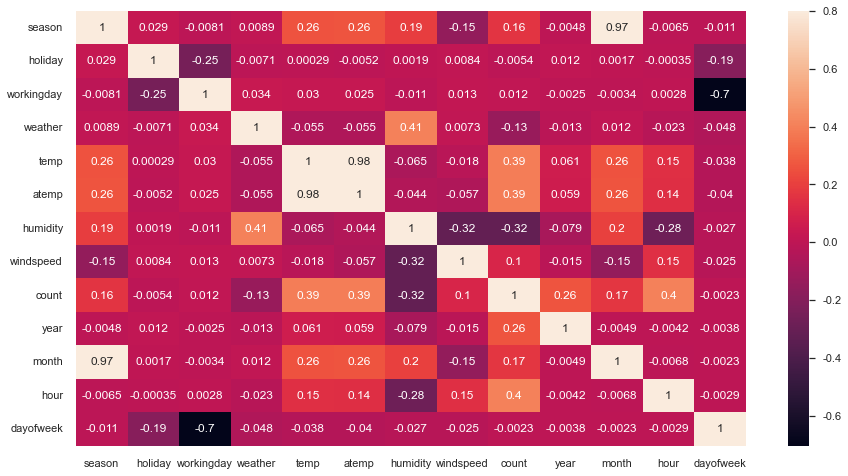

In [345]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(train.corr(),annot=True,vmax=.8)

#### 2.2 간단한 다중공선성 처리
    1. temp 와 atemp 컬럼 중 결과 값에 덜 영향을 미치는 컬럼을 삭제
    2. month 와 season 컬럼 중 결과 값에 덜 영향을 미치는 컬럼을 삭제

temp 컬럼 삭제 후 예측

In [269]:
features = ["season", "weather", "atemp", "humidity", "windspeed",'month',
            "year", "hour", "dayofweek", "holiday", "workingday"]

In [270]:
X_train = train[features]
X_test = test[features] 
display(X_train)
display(X_test)

,season,weather,atemp,humidity,windspeed,month,year,hour,dayofweek,holiday,workingday
0,1,1,14.395,81,0.0000,1,2011,0,5,0,0
1,1,1,13.635,80,0.0000,1,2011,1,5,0,0
2,1,1,13.635,80,0.0000,1,2011,2,5,0,0
3,1,1,14.395,75,0.0000,1,2011,3,5,0,0
4,1,1,14.395,75,0.0000,1,2011,4,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...
10881,4,1,19.695,50,26.0027,12,2012,19,2,0,1
10882,4,1,17.425,57,15.0013,12,2012,20,2,0,1
10883,4,1,15.910,61,15.0013,12,2012,21,2,0,1
10884,4,1,17.425,61,6.0032,12,2012,22,2,0,1


,season,weather,atemp,humidity,windspeed,month,year,hour,dayofweek,holiday,workingday
0,1,1,11.365,56,26.0027,1,2011,0,3,0,1
1,1,1,13.635,56,0.0000,1,2011,1,3,0,1
2,1,1,13.635,56,0.0000,1,2011,2,3,0,1
3,1,1,12.880,56,11.0014,1,2011,3,3,0,1
4,1,1,12.880,56,11.0014,1,2011,4,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...
6488,1,2,12.880,60,11.0014,12,2012,19,0,0,1
6489,1,2,12.880,60,11.0014,12,2012,20,0,0,1
6490,1,1,12.880,60,11.0014,12,2012,21,0,0,1
6491,1,1,13.635,56,8.9981,12,2012,22,0,0,1


In [273]:
# 랜덤 포레스트
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

train_input,test_input,train_target,test_target = train_test_split(X_train,y_train_log,random_state=42)

rf = RandomForestRegressor()


# 교차 검증
kfold = KFold(n_splits=10, random_state=1000, shuffle=True)
cross_score = cross_val_score(rf, X_train, y_train_log, cv=kfold, scoring=rmsle_score)
print("cross_val_score :",cross_score.mean())

rf.fit(train_input,train_target)
print('RandomForestRegressor train score : ',rf.score(train_input,train_target))
print('RandomForestRegressor test score : ',rf.score(test_input,test_target))

pred_train = rf.predict(train_input)
print('RMSLE RandomForestRegressor train score : ',RMSLE(np.exp(pred_train),np.exp(train_target)))
pred_test = rf.predict(test_input)
print('RMSLE RandomForestRegressor test score : ',RMSLE(np.exp(pred_test),np.exp(test_target)))

rf.fit(X_train,y_train_log)
final_pred = rf.predict(X_test)
# 결과 
submission = pd.read_csv('./bike-sharing-demand/sampleSubmission.csv')
submission['count'] = np.exp(final_pred)
submission.to_csv('RandomForestRegressor'+' {0:.5f}.csv'.format(RMSLE(np.exp(pred_test),np.exp(test_target))), index=False)
submission.head(10)

cross_val_score : 0.0811562448104969
RandomForestRegressor train score :  0.9934945320711529
RandomForestRegressor test score :  0.9564717210818613
RMSLE RandomForestRegressor train score :  0.10685587443404689
RMSLE RandomForestRegressor test score :  0.2775515439769973


,datetime,count
0,2011-01-20 00:00:00,10.711572
1,2011-01-20 01:00:00,6.435898
2,2011-01-20 02:00:00,4.058989
3,2011-01-20 03:00:00,4.055272
4,2011-01-20 04:00:00,3.556191
5,2011-01-20 05:00:00,5.524692
6,2011-01-20 06:00:00,34.375124
7,2011-01-20 07:00:00,89.968753
8,2011-01-20 08:00:00,199.060910
9,2011-01-20 09:00:00,125.408189


결과 : 0.43893

In [274]:
# 엑스트라 트리
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

train_input,test_input,train_target,test_target = train_test_split(X_train,y_train_log,random_state=42)

et = ExtraTreesRegressor()


# 교차 검증
kfold = KFold(n_splits=10, random_state=1000, shuffle=True)
cross_score = cross_val_score(et, X_train, y_train_log, cv=kfold, scoring=rmsle_score)
print("cross_val_score :",cross_score.mean())

et.fit(train_input,train_target)
print('ExtraTreesRegressor train score : ',et.score(train_input,train_target))
print('ExtraTreesRegressor test score : ',et.score(test_input,test_target))

pred_train = et.predict(train_input)
print('RMSLE ExtraTreesRegressor train score : ',RMSLE(np.exp(pred_train),np.exp(train_target)))
pred_test = et.predict(test_input)
print('RMSLE ExtraTreesRegressor test score : ',RMSLE(np.exp(pred_test),np.exp(test_target)))

et.fit(X_train,y_train_log)
final_pred = et.predict(X_test)
# 결과 
submission = pd.read_csv('./bike-sharing-demand/sampleSubmission.csv')
submission['count'] = np.exp(final_pred)
submission.to_csv('ExtraTreesRegressor'+' {0:.5f}.csv'.format(RMSLE(np.exp(pred_test),np.exp(test_target))), index=False)
submission.head(10)

cross_val_score : 0.08234766770541896
ExtraTreesRegressor train score :  0.999997381841576
ExtraTreesRegressor test score :  0.9539898374922466
RMSLE ExtraTreesRegressor train score :  0.0018077486519770026
RMSLE ExtraTreesRegressor test score :  0.2846198696216156


,datetime,count
0,2011-01-20 00:00:00,9.979837
1,2011-01-20 01:00:00,5.154867
2,2011-01-20 02:00:00,3.649797
3,2011-01-20 03:00:00,3.686617
4,2011-01-20 04:00:00,3.631706
5,2011-01-20 05:00:00,5.429365
6,2011-01-20 06:00:00,32.997863
7,2011-01-20 07:00:00,86.743395
8,2011-01-20 08:00:00,198.114838
9,2011-01-20 09:00:00,116.576438


* 결과 :0.42588

In [275]:
# 그래디언트부스팅
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

train_input,test_input,train_target,test_target = train_test_split(X_train,y_train_log,random_state=42)

gb = GradientBoostingRegressor()


# 교차 검증
kfold = KFold(n_splits=10, random_state=1000, shuffle=True)
cross_score = cross_val_score(gb, X_train, y_train_log, cv=kfold, scoring=rmsle_score)
print("cross_val_score :",cross_score.mean())

gb.fit(train_input,train_target)
print('GradientBoostingRegressor train score : ',gb.score(train_input,train_target))
print('GradientBoostingRegressor test score : ',gb.score(test_input,test_target))

pred_train = gb.predict(train_input)
print('RMSLE GradientBoostingRegressor train score : ',RMSLE(np.exp(pred_train),np.exp(train_target)))
pred_test = gb.predict(test_input)
print('RMSLE GradientBoostingRegressor test score : ',RMSLE(np.exp(pred_test),np.exp(test_target)))

gb.fit(X_train,y_train_log)
final_pred = gb.predict(X_test)
# 결과 
submission = pd.read_csv('./bike-sharing-demand/sampleSubmission.csv')
submission['count'] = np.exp(final_pred)
submission.to_csv('GradientBoostingRegressor'+' {0:.5f}.csv'.format(RMSLE(np.exp(pred_test),np.exp(test_target))), index=False)
submission.head(10)

cross_val_score : 0.09471464101804081
GradientBoostingRegressor train score :  0.9320509084918347
GradientBoostingRegressor test score :  0.9276762758590474
RMSLE GradientBoostingRegressor train score :  0.3521902504295316
RMSLE GradientBoostingRegressor test score :  0.36308386559871164


,datetime,count
0,2011-01-20 00:00:00,8.982287
1,2011-01-20 01:00:00,5.878251
2,2011-01-20 02:00:00,3.775819
3,2011-01-20 03:00:00,2.979581
4,2011-01-20 04:00:00,2.979581
5,2011-01-20 05:00:00,8.240768
6,2011-01-20 06:00:00,28.223515
7,2011-01-20 07:00:00,57.490905
8,2011-01-20 08:00:00,103.156374
9,2011-01-20 09:00:00,87.030440


* 실행 결과 : 0.47140

* 결과가 악화 되는 것을 확인
* 이번에는 temp 대신 atemp를 삭제 후 다시 테스트

In [278]:
features = ["season", "weather", "temp", "humidity", "windspeed",'month',
            "year", "hour", "dayofweek", "holiday", "workingday"]

In [279]:
X_train = train[features]
X_test = test[features] 
display(X_train)
display(X_test)

,season,weather,temp,humidity,windspeed,month,year,hour,dayofweek,holiday,workingday
0,1,1,9.84,81,0.0000,1,2011,0,5,0,0
1,1,1,9.02,80,0.0000,1,2011,1,5,0,0
2,1,1,9.02,80,0.0000,1,2011,2,5,0,0
3,1,1,9.84,75,0.0000,1,2011,3,5,0,0
4,1,1,9.84,75,0.0000,1,2011,4,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...
10881,4,1,15.58,50,26.0027,12,2012,19,2,0,1
10882,4,1,14.76,57,15.0013,12,2012,20,2,0,1
10883,4,1,13.94,61,15.0013,12,2012,21,2,0,1
10884,4,1,13.94,61,6.0032,12,2012,22,2,0,1


,season,weather,temp,humidity,windspeed,month,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,56,26.0027,1,2011,0,3,0,1
1,1,1,10.66,56,0.0000,1,2011,1,3,0,1
2,1,1,10.66,56,0.0000,1,2011,2,3,0,1
3,1,1,10.66,56,11.0014,1,2011,3,3,0,1
4,1,1,10.66,56,11.0014,1,2011,4,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...
6488,1,2,10.66,60,11.0014,12,2012,19,0,0,1
6489,1,2,10.66,60,11.0014,12,2012,20,0,0,1
6490,1,1,10.66,60,11.0014,12,2012,21,0,0,1
6491,1,1,10.66,56,8.9981,12,2012,22,0,0,1


In [280]:
# 랜덤 포레스트
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

train_input,test_input,train_target,test_target = train_test_split(X_train,y_train_log,random_state=42)

rf = RandomForestRegressor()


# 교차 검증
kfold = KFold(n_splits=10, random_state=1000, shuffle=True)
cross_score = cross_val_score(rf, X_train, y_train_log, cv=kfold, scoring=rmsle_score)
print("cross_val_score :",cross_score.mean())

rf.fit(train_input,train_target)
print('RandomForestRegressor train score : ',rf.score(train_input,train_target))
print('RandomForestRegressor test score : ',rf.score(test_input,test_target))

pred_train = rf.predict(train_input)
print('RMSLE RandomForestRegressor train score : ',RMSLE(np.exp(pred_train),np.exp(train_target)))
pred_test = rf.predict(test_input)
print('RMSLE RandomForestRegressor test score : ',RMSLE(np.exp(pred_test),np.exp(test_target)))

rf.fit(X_train,y_train_log)
final_pred = rf.predict(X_test)
# 결과 
submission = pd.read_csv('./bike-sharing-demand/sampleSubmission.csv')
submission['count'] = np.exp(final_pred)
submission.to_csv('RandomForestRegressor'+' {0:.5f}.csv'.format(RMSLE(np.exp(pred_test),np.exp(test_target))), index=False)
submission.head(10)

cross_val_score : 0.08065354071919459
RandomForestRegressor train score :  0.9933809218700843
RandomForestRegressor test score :  0.9569996896135626
RMSLE RandomForestRegressor train score :  0.10779265681182768
RMSLE RandomForestRegressor test score :  0.27588477263650224


,datetime,count
0,2011-01-20 00:00:00,11.449490
1,2011-01-20 01:00:00,5.720117
2,2011-01-20 02:00:00,3.951548
3,2011-01-20 03:00:00,4.078672
4,2011-01-20 04:00:00,3.675197
5,2011-01-20 05:00:00,6.555995
6,2011-01-20 06:00:00,36.395069
7,2011-01-20 07:00:00,93.174516
8,2011-01-20 08:00:00,211.229242
9,2011-01-20 09:00:00,126.180375


* 실행 결과 : 0.44032

In [281]:
# 엑스트라 트리
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

train_input,test_input,train_target,test_target = train_test_split(X_train,y_train_log,random_state=42)

et = ExtraTreesRegressor()


# 교차 검증
kfold = KFold(n_splits=10, random_state=1000, shuffle=True)
cross_score = cross_val_score(et, X_train, y_train_log, cv=kfold, scoring=rmsle_score)
print("cross_val_score :",cross_score.mean())

et.fit(train_input,train_target)
print('ExtraTreesRegressor train score : ',et.score(train_input,train_target))
print('ExtraTreesRegressor test score : ',et.score(test_input,test_target))

pred_train = et.predict(train_input)
print('RMSLE ExtraTreesRegressor train score : ',RMSLE(np.exp(pred_train),np.exp(train_target)))
pred_test = et.predict(test_input)
print('RMSLE ExtraTreesRegressor test score : ',RMSLE(np.exp(pred_test),np.exp(test_target)))

et.fit(X_train,y_train_log)
final_pred = et.predict(X_test)
# 결과 
submission = pd.read_csv('./bike-sharing-demand/sampleSubmission.csv')
submission['count'] = np.exp(final_pred)
submission.to_csv('ExtraTreesRegressor'+' {0:.5f}.csv'.format(RMSLE(np.exp(pred_test),np.exp(test_target))), index=False)
submission.head(10)

cross_val_score : 0.08215565592430184
ExtraTreesRegressor train score :  0.999997381841576
ExtraTreesRegressor test score :  0.9546620521771575
RMSLE ExtraTreesRegressor train score :  0.0018077486519770026
RMSLE ExtraTreesRegressor test score :  0.2824022666774726


,datetime,count
0,2011-01-20 00:00:00,9.918071
1,2011-01-20 01:00:00,5.042914
2,2011-01-20 02:00:00,3.803222
3,2011-01-20 03:00:00,3.715322
4,2011-01-20 04:00:00,3.974480
5,2011-01-20 05:00:00,5.339196
6,2011-01-20 06:00:00,35.106409
7,2011-01-20 07:00:00,88.553131
8,2011-01-20 08:00:00,199.614091
9,2011-01-20 09:00:00,120.351095


* 실행 결과 : 0.42435

In [282]:
# 그래디언트부스팅
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

train_input,test_input,train_target,test_target = train_test_split(X_train,y_train_log,random_state=42)

gb = GradientBoostingRegressor()


# 교차 검증
kfold = KFold(n_splits=10, random_state=1000, shuffle=True)
cross_score = cross_val_score(gb, X_train, y_train_log, cv=kfold, scoring=rmsle_score)
print("cross_val_score :",cross_score.mean())

gb.fit(train_input,train_target)
print('GradientBoostingRegressor train score : ',gb.score(train_input,train_target))
print('GradientBoostingRegressor test score : ',gb.score(test_input,test_target))

pred_train = gb.predict(train_input)
print('RMSLE GradientBoostingRegressor train score : ',RMSLE(np.exp(pred_train),np.exp(train_target)))
pred_test = gb.predict(test_input)
print('RMSLE GradientBoostingRegressor test score : ',RMSLE(np.exp(pred_test),np.exp(test_target)))

gb.fit(X_train,y_train_log)
final_pred = gb.predict(X_test)
# 결과 
submission = pd.read_csv('./bike-sharing-demand/sampleSubmission.csv')
submission['count'] = np.exp(final_pred)
submission.to_csv('GradientBoostingRegressor'+' {0:.5f}.csv'.format(RMSLE(np.exp(pred_test),np.exp(test_target))), index=False)
submission.head(10)

cross_val_score : 0.09468549081271191
GradientBoostingRegressor train score :  0.934950623302105
GradientBoostingRegressor test score :  0.9322259688311821
RMSLE GradientBoostingRegressor train score :  0.34441273421528934
RMSLE GradientBoostingRegressor test score :  0.3515377876209476


,datetime,count
0,2011-01-20 00:00:00,8.435203
1,2011-01-20 01:00:00,5.891668
2,2011-01-20 02:00:00,3.886680
3,2011-01-20 03:00:00,2.868069
4,2011-01-20 04:00:00,2.868069
5,2011-01-20 05:00:00,7.798877
6,2011-01-20 06:00:00,25.148694
7,2011-01-20 07:00:00,52.843297
8,2011-01-20 08:00:00,93.352661
9,2011-01-20 09:00:00,77.442970


* 실행 결과 : 0.48957

* 속성 처리 후 오히려 결과가 악화 되는 것을 확인

* 이번에는 month 컬럼과 season 컬럼을 처리
* month 컬럼을 삭제 후 테스트 진행

In [287]:
features = ["season", "weather", "temp","atemp", "humidity", "windspeed",
            "year", "hour", "dayofweek", "holiday", "workingday"]

In [288]:
X_train = train[features]
X_test = test[features] 
display(X_train)
display(X_test)

,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,9.84,14.395,81,0.0000,2011,0,5,0,0
1,1,1,9.02,13.635,80,0.0000,2011,1,5,0,0
2,1,1,9.02,13.635,80,0.0000,2011,2,5,0,0
3,1,1,9.84,14.395,75,0.0000,2011,3,5,0,0
4,1,1,9.84,14.395,75,0.0000,2011,4,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...
10881,4,1,15.58,19.695,50,26.0027,2012,19,2,0,1
10882,4,1,14.76,17.425,57,15.0013,2012,20,2,0,1
10883,4,1,13.94,15.910,61,15.0013,2012,21,2,0,1
10884,4,1,13.94,17.425,61,6.0032,2012,22,2,0,1


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...
6488,1,2,10.66,12.880,60,11.0014,2012,19,0,0,1
6489,1,2,10.66,12.880,60,11.0014,2012,20,0,0,1
6490,1,1,10.66,12.880,60,11.0014,2012,21,0,0,1
6491,1,1,10.66,13.635,56,8.9981,2012,22,0,0,1


In [289]:
# 랜덤 포레스트
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

train_input,test_input,train_target,test_target = train_test_split(X_train,y_train_log,random_state=42)

rf = RandomForestRegressor()


# 교차 검증
kfold = KFold(n_splits=10, random_state=1000, shuffle=True)
cross_score = cross_val_score(rf, X_train, y_train_log, cv=kfold, scoring=rmsle_score)
print("cross_val_score :",cross_score.mean())

rf.fit(train_input,train_target)
print('RandomForestRegressor train score : ',rf.score(train_input,train_target))
print('RandomForestRegressor test score : ',rf.score(test_input,test_target))

pred_train = rf.predict(train_input)
print('RMSLE RandomForestRegressor train score : ',RMSLE(np.exp(pred_train),np.exp(train_target)))
pred_test = rf.predict(test_input)
print('RMSLE RandomForestRegressor test score : ',RMSLE(np.exp(pred_test),np.exp(test_target)))

rf.fit(X_train,y_train_log)
final_pred = rf.predict(X_test)
# 결과 
submission = pd.read_csv('./bike-sharing-demand/sampleSubmission.csv')
submission['count'] = np.exp(final_pred)
submission.to_csv('RandomForestRegressor'+' {0:.5f}.csv'.format(RMSLE(np.exp(pred_test),np.exp(test_target))), index=False)
submission.head(10)

cross_val_score : 0.08199686133243729
RandomForestRegressor train score :  0.9930712556435048
RandomForestRegressor test score :  0.9545218208003896
RMSLE RandomForestRegressor train score :  0.1104369715570574
RMSLE RandomForestRegressor test score :  0.28425666087413526


,datetime,count
0,2011-01-20 00:00:00,12.742855
1,2011-01-20 01:00:00,5.694723
2,2011-01-20 02:00:00,3.857956
3,2011-01-20 03:00:00,4.307199
4,2011-01-20 04:00:00,3.646902
5,2011-01-20 05:00:00,6.796472
6,2011-01-20 06:00:00,38.982059
7,2011-01-20 07:00:00,108.273169
8,2011-01-20 08:00:00,238.133535
9,2011-01-20 09:00:00,132.695690


* 실행 결과 : 0.39690

In [290]:
# 엑스트라 트리
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

train_input,test_input,train_target,test_target = train_test_split(X_train,y_train_log,random_state=42)

et = ExtraTreesRegressor()


# 교차 검증
kfold = KFold(n_splits=10, random_state=1000, shuffle=True)
cross_score = cross_val_score(et, X_train, y_train_log, cv=kfold, scoring=rmsle_score)
print("cross_val_score :",cross_score.mean())

et.fit(train_input,train_target)
print('ExtraTreesRegressor train score : ',et.score(train_input,train_target))
print('ExtraTreesRegressor test score : ',et.score(test_input,test_target))

pred_train = et.predict(train_input)
print('RMSLE ExtraTreesRegressor train score : ',RMSLE(np.exp(pred_train),np.exp(train_target)))
pred_test = et.predict(test_input)
print('RMSLE ExtraTreesRegressor test score : ',RMSLE(np.exp(pred_test),np.exp(test_target)))

et.fit(X_train,y_train_log)
final_pred = et.predict(X_test)
# 결과 
submission = pd.read_csv('./bike-sharing-demand/sampleSubmission.csv')
submission['count'] = np.exp(final_pred)
submission.to_csv('ExtraTreesRegressor'+' {0:.5f}.csv'.format(RMSLE(np.exp(pred_test),np.exp(test_target))), index=False)
submission.head(10)

cross_val_score : 0.08381505037191508
ExtraTreesRegressor train score :  0.9999671332919993
ExtraTreesRegressor test score :  0.9521946591342783
RMSLE ExtraTreesRegressor train score :  0.007741097419466745
RMSLE ExtraTreesRegressor test score :  0.2904345442822724


,datetime,count
0,2011-01-20 00:00:00,12.364062
1,2011-01-20 01:00:00,5.317709
2,2011-01-20 02:00:00,3.938053
3,2011-01-20 03:00:00,4.635696
4,2011-01-20 04:00:00,3.848658
5,2011-01-20 05:00:00,6.054968
6,2011-01-20 06:00:00,39.767856
7,2011-01-20 07:00:00,103.086918
8,2011-01-20 08:00:00,243.851655
9,2011-01-20 09:00:00,127.945545


* 실행 결과 : 0.39899

In [292]:
# 그래디언트부스팅
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

train_input,test_input,train_target,test_target = train_test_split(X_train,y_train_log,random_state=42)

gb = GradientBoostingRegressor()


# 교차 검증
kfold = KFold(n_splits=10, random_state=1000, shuffle=True)
cross_score = cross_val_score(gb, X_train, y_train_log, cv=kfold, scoring=rmsle_score)
print("cross_val_score :",cross_score.mean())

gb.fit(train_input,train_target)
print('GradientBoostingRegressor train score : ',gb.score(train_input,train_target))
print('GradientBoostingRegressor test score : ',gb.score(test_input,test_target))

pred_train = gb.predict(train_input)
print('RMSLE GradientBoostingRegressor train score : ',RMSLE(np.exp(pred_train),np.exp(train_target)))
pred_test = gb.predict(test_input)
print('RMSLE GradientBoostingRegressor test score : ',RMSLE(np.exp(pred_test),np.exp(test_target)))

gb.fit(X_train,y_train_log)
final_pred = gb.predict(X_test)
# 결과 
submission = pd.read_csv('./bike-sharing-demand/sampleSubmission.csv')
submission['count'] = np.exp(final_pred)
submission.to_csv('GradientBoostingRegressor'+' {0:.5f}.csv'.format(RMSLE(np.exp(pred_test),np.exp(test_target))), index=False)
submission.head(10)

cross_val_score : 0.09598113609717862
GradientBoostingRegressor train score :  0.9299624331442008
GradientBoostingRegressor test score :  0.9266034530483133
RMSLE GradientBoostingRegressor train score :  0.3579159430873644
RMSLE GradientBoostingRegressor test score :  0.3663049924258417


,datetime,count
0,2011-01-20 00:00:00,9.583050
1,2011-01-20 01:00:00,6.333902
2,2011-01-20 02:00:00,4.144961
3,2011-01-20 03:00:00,3.072299
4,2011-01-20 04:00:00,3.072299
5,2011-01-20 05:00:00,8.709252
6,2011-01-20 06:00:00,28.953383
7,2011-01-20 07:00:00,66.050925
8,2011-01-20 08:00:00,121.661443
9,2011-01-20 09:00:00,77.851932


* 실행 결과 : 0.44349

* month 컬럼 제거 후 전체적으로 성능이 좋아짐을 판단

* 이번에는 season 컬럼을 삭제

In [295]:
features = ["weather", "temp","atemp", "humidity", "windspeed","month",
            "year", "hour", "dayofweek", "holiday", "workingday"]

In [296]:
X_train = train[features]
X_test = test[features] 
display(X_train)
display(X_test)

,weather,temp,atemp,humidity,windspeed,month,year,hour,dayofweek,holiday,workingday
0,1,9.84,14.395,81,0.0000,1,2011,0,5,0,0
1,1,9.02,13.635,80,0.0000,1,2011,1,5,0,0
2,1,9.02,13.635,80,0.0000,1,2011,2,5,0,0
3,1,9.84,14.395,75,0.0000,1,2011,3,5,0,0
4,1,9.84,14.395,75,0.0000,1,2011,4,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...
10881,1,15.58,19.695,50,26.0027,12,2012,19,2,0,1
10882,1,14.76,17.425,57,15.0013,12,2012,20,2,0,1
10883,1,13.94,15.910,61,15.0013,12,2012,21,2,0,1
10884,1,13.94,17.425,61,6.0032,12,2012,22,2,0,1


,weather,temp,atemp,humidity,windspeed,month,year,hour,dayofweek,holiday,workingday
0,1,10.66,11.365,56,26.0027,1,2011,0,3,0,1
1,1,10.66,13.635,56,0.0000,1,2011,1,3,0,1
2,1,10.66,13.635,56,0.0000,1,2011,2,3,0,1
3,1,10.66,12.880,56,11.0014,1,2011,3,3,0,1
4,1,10.66,12.880,56,11.0014,1,2011,4,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...
6488,2,10.66,12.880,60,11.0014,12,2012,19,0,0,1
6489,2,10.66,12.880,60,11.0014,12,2012,20,0,0,1
6490,1,10.66,12.880,60,11.0014,12,2012,21,0,0,1
6491,1,10.66,13.635,56,8.9981,12,2012,22,0,0,1


In [297]:
# 랜덤 포레스트
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

train_input,test_input,train_target,test_target = train_test_split(X_train,y_train_log,random_state=42)

rf = RandomForestRegressor()


# 교차 검증
kfold = KFold(n_splits=10, random_state=1000, shuffle=True)
cross_score = cross_val_score(rf, X_train, y_train_log, cv=kfold, scoring=rmsle_score)
print("cross_val_score :",cross_score.mean())

rf.fit(train_input,train_target)
print('RandomForestRegressor train score : ',rf.score(train_input,train_target))
print('RandomForestRegressor test score : ',rf.score(test_input,test_target))

pred_train = rf.predict(train_input)
print('RMSLE RandomForestRegressor train score : ',RMSLE(np.exp(pred_train),np.exp(train_target)))
pred_test = rf.predict(test_input)
print('RMSLE RandomForestRegressor test score : ',RMSLE(np.exp(pred_test),np.exp(test_target)))

rf.fit(X_train,y_train_log)
final_pred = rf.predict(X_test)
# 결과 
submission = pd.read_csv('./bike-sharing-demand/sampleSubmission.csv')
submission['count'] = np.exp(final_pred)
submission.to_csv('RandomForestRegressor'+' {0:.5f}.csv'.format(RMSLE(np.exp(pred_test),np.exp(test_target))), index=False)
submission.head(10)

cross_val_score : 0.08103818628419167
RandomForestRegressor train score :  0.9934308184529568
RandomForestRegressor test score :  0.9558747462611868
RMSLE RandomForestRegressor train score :  0.10728780410489361
RMSLE RandomForestRegressor test score :  0.27953843908132553


,datetime,count
0,2011-01-20 00:00:00,10.968500
1,2011-01-20 01:00:00,5.886248
2,2011-01-20 02:00:00,4.052217
3,2011-01-20 03:00:00,4.397514
4,2011-01-20 04:00:00,3.824091
5,2011-01-20 05:00:00,6.901710
6,2011-01-20 06:00:00,36.277309
7,2011-01-20 07:00:00,94.726516
8,2011-01-20 08:00:00,206.384808
9,2011-01-20 09:00:00,125.950275


* 실행 결과 : 0.46014

In [298]:
# 그래디언트부스팅
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

train_input,test_input,train_target,test_target = train_test_split(X_train,y_train_log,random_state=42)

gb = GradientBoostingRegressor()


# 교차 검증
kfold = KFold(n_splits=10, random_state=1000, shuffle=True)
cross_score = cross_val_score(gb, X_train, y_train_log, cv=kfold, scoring=rmsle_score)
print("cross_val_score :",cross_score.mean())

gb.fit(train_input,train_target)
print('GradientBoostingRegressor train score : ',gb.score(train_input,train_target))
print('GradientBoostingRegressor test score : ',gb.score(test_input,test_target))

pred_train = gb.predict(train_input)
print('RMSLE GradientBoostingRegressor train score : ',RMSLE(np.exp(pred_train),np.exp(train_target)))
pred_test = gb.predict(test_input)
print('RMSLE GradientBoostingRegressor test score : ',RMSLE(np.exp(pred_test),np.exp(test_target)))

gb.fit(X_train,y_train_log)
final_pred = gb.predict(X_test)
# 결과 
submission = pd.read_csv('./bike-sharing-demand/sampleSubmission.csv')
submission['count'] = np.exp(final_pred)
submission.to_csv('GradientBoostingRegressor'+' {0:.5f}.csv'.format(RMSLE(np.exp(pred_test),np.exp(test_target))), index=False)
submission.head(10)

cross_val_score : 0.09468445804704051
GradientBoostingRegressor train score :  0.9263463157075545
GradientBoostingRegressor test score :  0.922406958775831
RMSLE GradientBoostingRegressor train score :  0.3672120364370387
RMSLE GradientBoostingRegressor test score :  0.37672200480818924


,datetime,count
0,2011-01-20 00:00:00,8.780907
1,2011-01-20 01:00:00,5.832957
2,2011-01-20 02:00:00,3.887398
3,2011-01-20 03:00:00,3.033668
4,2011-01-20 04:00:00,3.033668
5,2011-01-20 05:00:00,7.927656
6,2011-01-20 06:00:00,27.786203
7,2011-01-20 07:00:00,60.950938
8,2011-01-20 08:00:00,105.755041
9,2011-01-20 09:00:00,82.560948


* 실행 결과 : 0.48315

* season 과 month 중에서 month 컬럼이 중요하지 않은 것을 판단.
* -> month 컬럼 삭제

* month 컬럼 삭제 후 temp 와 atemp 다시 시도
* atemp 삭제

In [302]:
features = ["season","weather", "temp", "humidity", "windspeed",
            "year", "hour", "dayofweek", "holiday", "workingday"]

In [303]:
X_train = train[features]
X_test = test[features] 
display(X_train)
display(X_test)

,season,weather,temp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,9.84,81,0.0000,2011,0,5,0,0
1,1,1,9.02,80,0.0000,2011,1,5,0,0
2,1,1,9.02,80,0.0000,2011,2,5,0,0
3,1,1,9.84,75,0.0000,2011,3,5,0,0
4,1,1,9.84,75,0.0000,2011,4,5,0,0
...,...,...,...,...,...,...,...,...,...,...
10881,4,1,15.58,50,26.0027,2012,19,2,0,1
10882,4,1,14.76,57,15.0013,2012,20,2,0,1
10883,4,1,13.94,61,15.0013,2012,21,2,0,1
10884,4,1,13.94,61,6.0032,2012,22,2,0,1


,season,weather,temp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,56,26.0027,2011,0,3,0,1
1,1,1,10.66,56,0.0000,2011,1,3,0,1
2,1,1,10.66,56,0.0000,2011,2,3,0,1
3,1,1,10.66,56,11.0014,2011,3,3,0,1
4,1,1,10.66,56,11.0014,2011,4,3,0,1
...,...,...,...,...,...,...,...,...,...,...
6488,1,2,10.66,60,11.0014,2012,19,0,0,1
6489,1,2,10.66,60,11.0014,2012,20,0,0,1
6490,1,1,10.66,60,11.0014,2012,21,0,0,1
6491,1,1,10.66,56,8.9981,2012,22,0,0,1


In [304]:
# 랜덤 포레스트
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

train_input,test_input,train_target,test_target = train_test_split(X_train,y_train_log,random_state=42)

rf = RandomForestRegressor()


# 교차 검증
kfold = KFold(n_splits=10, random_state=1000, shuffle=True)
cross_score = cross_val_score(rf, X_train, y_train_log, cv=kfold, scoring=rmsle_score)
print("cross_val_score :",cross_score.mean())

rf.fit(train_input,train_target)
print('RandomForestRegressor train score : ',rf.score(train_input,train_target))
print('RandomForestRegressor test score : ',rf.score(test_input,test_target))

pred_train = rf.predict(train_input)
print('RMSLE RandomForestRegressor train score : ',RMSLE(np.exp(pred_train),np.exp(train_target)))
pred_test = rf.predict(test_input)
print('RMSLE RandomForestRegressor test score : ',RMSLE(np.exp(pred_test),np.exp(test_target)))

rf.fit(X_train,y_train_log)
final_pred = rf.predict(X_test)
# 결과 
submission = pd.read_csv('./bike-sharing-demand/sampleSubmission.csv')
submission['count'] = np.exp(final_pred)
submission.to_csv('RandomForestRegressor'+' {0:.5f}.csv'.format(RMSLE(np.exp(pred_test),np.exp(test_target))), index=False)
submission.head(10)

cross_val_score : 0.08188548663220604
RandomForestRegressor train score :  0.9932789371181812
RandomForestRegressor test score :  0.9547494170947656
RMSLE RandomForestRegressor train score :  0.10887733460008323
RMSLE RandomForestRegressor test score :  0.28341153143120984


,datetime,count
0,2011-01-20 00:00:00,12.318397
1,2011-01-20 01:00:00,5.567201
2,2011-01-20 02:00:00,4.278974
3,2011-01-20 03:00:00,3.850863
4,2011-01-20 04:00:00,3.512363
5,2011-01-20 05:00:00,7.189144
6,2011-01-20 06:00:00,39.318781
7,2011-01-20 07:00:00,109.534704
8,2011-01-20 08:00:00,239.683372
9,2011-01-20 09:00:00,138.032403


* 실행 결과 : 0.39915

In [305]:
# 그래디언트부스팅
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

train_input,test_input,train_target,test_target = train_test_split(X_train,y_train_log,random_state=42)

gb = GradientBoostingRegressor()


# 교차 검증
kfold = KFold(n_splits=10, random_state=1000, shuffle=True)
cross_score = cross_val_score(gb, X_train, y_train_log, cv=kfold, scoring=rmsle_score)
print("cross_val_score :",cross_score.mean())

gb.fit(train_input,train_target)
print('GradientBoostingRegressor train score : ',gb.score(train_input,train_target))
print('GradientBoostingRegressor test score : ',gb.score(test_input,test_target))

pred_train = gb.predict(train_input)
print('RMSLE GradientBoostingRegressor train score : ',RMSLE(np.exp(pred_train),np.exp(train_target)))
pred_test = gb.predict(test_input)
print('RMSLE GradientBoostingRegressor test score : ',RMSLE(np.exp(pred_test),np.exp(test_target)))

gb.fit(X_train,y_train_log)
final_pred = gb.predict(X_test)
# 결과 
submission = pd.read_csv('./bike-sharing-demand/sampleSubmission.csv')
submission['count'] = np.exp(final_pred)
submission.to_csv('GradientBoostingRegressor'+' {0:.5f}.csv'.format(RMSLE(np.exp(pred_test),np.exp(test_target))), index=False)
submission.head(10)

cross_val_score : 0.09424186129983061
GradientBoostingRegressor train score :  0.9326102192934209
GradientBoostingRegressor test score :  0.9295335500918765
RMSLE GradientBoostingRegressor train score :  0.35079000816792844
RMSLE GradientBoostingRegressor test score :  0.358736761963191


,datetime,count
0,2011-01-20 00:00:00,9.113577
1,2011-01-20 01:00:00,6.328251
2,2011-01-20 02:00:00,4.107377
3,2011-01-20 03:00:00,3.212928
4,2011-01-20 04:00:00,3.212928
5,2011-01-20 05:00:00,8.397133
6,2011-01-20 06:00:00,27.527741
7,2011-01-20 07:00:00,65.826608
8,2011-01-20 08:00:00,123.732335
9,2011-01-20 09:00:00,78.859207


* 실행 결과 : 0.44230

In [306]:
# 히스트 그래디언트부스팅
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

train_input,test_input,train_target,test_target = train_test_split(X_train,y_train_log,random_state=42)

hgb = HistGradientBoostingRegressor()


# 교차 검증
kfold = KFold(n_splits=10, random_state=1000, shuffle=True)
cross_score = cross_val_score(hgb, X_train, y_train_log, cv=kfold, scoring=rmsle_score)
print("cross_val_score :",cross_score.mean())

hgb.fit(train_input,train_target)
print('HistGradientBoostingRegressor train score : ',hgb.score(train_input,train_target))
print('HistGradientBoostingRegressor test score : ',hgb.score(test_input,test_target))

pred_train = hgb.predict(train_input)
print('RMSLE HistGradientBoostingRegressor train score : ',RMSLE(np.exp(pred_train),np.exp(train_target)))
pred_test = hgb.predict(test_input)
print('RMSLE HistGradientBoostingRegressor test score : ',RMSLE(np.exp(pred_test),np.exp(test_target)))

hgb.fit(X_train,y_train_log)
final_pred = hgb.predict(X_test)
# 결과 
submission = pd.read_csv('./bike-sharing-demand/sampleSubmission.csv')
submission['count'] = np.exp(final_pred)
submission.to_csv('HistGradientBoostingRegressor'+' {0:.5f}.csv'.format(RMSLE(np.exp(pred_test),np.exp(test_target))), index=False)
submission.head(10)

cross_val_score : 0.07841912719043236
HistGradientBoostingRegressor train score :  0.9687695714424117
HistGradientBoostingRegressor test score :  0.9560273891002944
RMSLE HistGradientBoostingRegressor train score :  0.2356390055967299
RMSLE HistGradientBoostingRegressor test score :  0.28018552591956486


,datetime,count
0,2011-01-20 00:00:00,10.868976
1,2011-01-20 01:00:00,6.018344
2,2011-01-20 02:00:00,3.998058
3,2011-01-20 03:00:00,2.931350
4,2011-01-20 04:00:00,2.888746
5,2011-01-20 05:00:00,6.320425
6,2011-01-20 06:00:00,35.570600
7,2011-01-20 07:00:00,107.610446
8,2011-01-20 08:00:00,218.219847
9,2011-01-20 09:00:00,141.392796


* 실행 결과 : 0.38162

In [307]:
# ligntGBM
from lightgbm import LGBMRegressor 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

train_input,test_input,train_target,test_target = train_test_split(X_train,y_train_log,random_state=42)

lgb = LGBMRegressor()


# 교차 검증
kfold = KFold(n_splits=10, random_state=1000, shuffle=True)
cross_score = cross_val_score(lgb, X_train, y_train_log, cv=kfold, scoring=rmsle_score)
print("cross_val_score :",cross_score.mean())

lgb.fit(train_input,train_target)
print('LGBMRegressor train score : ',lgb.score(train_input,train_target))
print('LGBMRegressor test score : ',lgb.score(test_input,test_target))

lgb.fit(X_train,y_train_log)
pred_train = lgb.predict(train_input)
print('RMSLE LGBMRegressor train score : ',RMSLE(np.exp(pred_train),np.exp(train_target)))
pred_test = lgb.predict(test_input)
print('RMSLE LGBMRegressor test score : ',RMSLE(np.exp(pred_test),np.exp(test_target)))

final_pred = lgb.predict(X_test)
# 결과 
submission = pd.read_csv('./bike-sharing-demand/sampleSubmission.csv')
submission['count'] = np.exp(final_pred)
submission.to_csv('LGBMRegressor'+' {0:.5f}.csv'.format(RMSLE(np.exp(pred_test),np.exp(test_target))), index=False)
submission.head(10)

cross_val_score : 0.07925097045190233
LGBMRegressor train score :  0.9704032234911987
LGBMRegressor test score :  0.956685469532394
RMSLE LGBMRegressor train score :  0.23540997210816908
RMSLE LGBMRegressor test score :  0.23394702024889433


,datetime,count
0,2011-01-20 00:00:00,10.808951
1,2011-01-20 01:00:00,5.609086
2,2011-01-20 02:00:00,3.671604
3,2011-01-20 03:00:00,3.101601
4,2011-01-20 04:00:00,2.908661
5,2011-01-20 05:00:00,6.808012
6,2011-01-20 06:00:00,35.263593
7,2011-01-20 07:00:00,116.584932
8,2011-01-20 08:00:00,205.697293
9,2011-01-20 09:00:00,132.980836


* 실행 결과 : 0.37731

* atemp 대신 temp 삭제 후 다시 시도

In [309]:
features = ["season","weather", "atemp", "humidity", "windspeed",
            "year", "hour", "dayofweek", "holiday", "workingday"]

In [310]:
X_train = train[features]
X_test = test[features] 
display(X_train)
display(X_test)

,season,weather,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,14.395,81,0.0000,2011,0,5,0,0
1,1,1,13.635,80,0.0000,2011,1,5,0,0
2,1,1,13.635,80,0.0000,2011,2,5,0,0
3,1,1,14.395,75,0.0000,2011,3,5,0,0
4,1,1,14.395,75,0.0000,2011,4,5,0,0
...,...,...,...,...,...,...,...,...,...,...
10881,4,1,19.695,50,26.0027,2012,19,2,0,1
10882,4,1,17.425,57,15.0013,2012,20,2,0,1
10883,4,1,15.910,61,15.0013,2012,21,2,0,1
10884,4,1,17.425,61,6.0032,2012,22,2,0,1


,season,weather,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,11.365,56,26.0027,2011,0,3,0,1
1,1,1,13.635,56,0.0000,2011,1,3,0,1
2,1,1,13.635,56,0.0000,2011,2,3,0,1
3,1,1,12.880,56,11.0014,2011,3,3,0,1
4,1,1,12.880,56,11.0014,2011,4,3,0,1
...,...,...,...,...,...,...,...,...,...,...
6488,1,2,12.880,60,11.0014,2012,19,0,0,1
6489,1,2,12.880,60,11.0014,2012,20,0,0,1
6490,1,1,12.880,60,11.0014,2012,21,0,0,1
6491,1,1,13.635,56,8.9981,2012,22,0,0,1


In [311]:
# 랜덤 포레스트
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

train_input,test_input,train_target,test_target = train_test_split(X_train,y_train_log,random_state=42)

rf = RandomForestRegressor()


# 교차 검증
kfold = KFold(n_splits=10, random_state=1000, shuffle=True)
cross_score = cross_val_score(rf, X_train, y_train_log, cv=kfold, scoring=rmsle_score)
print("cross_val_score :",cross_score.mean())

rf.fit(train_input,train_target)
print('RandomForestRegressor train score : ',rf.score(train_input,train_target))
print('RandomForestRegressor test score : ',rf.score(test_input,test_target))

pred_train = rf.predict(train_input)
print('RMSLE RandomForestRegressor train score : ',RMSLE(np.exp(pred_train),np.exp(train_target)))
pred_test = rf.predict(test_input)
print('RMSLE RandomForestRegressor test score : ',RMSLE(np.exp(pred_test),np.exp(test_target)))

rf.fit(X_train,y_train_log)
final_pred = rf.predict(X_test)
# 결과 
submission = pd.read_csv('./bike-sharing-demand/sampleSubmission.csv')
submission['count'] = np.exp(final_pred)
submission.to_csv('RandomForestRegressor'+' {0:.5f}.csv'.format(RMSLE(np.exp(pred_test),np.exp(test_target))), index=False)
submission.head(10)

cross_val_score : 0.08254460098250421
RandomForestRegressor train score :  0.9932238953989457
RandomForestRegressor test score :  0.9537663913665085
RMSLE RandomForestRegressor train score :  0.10923830144173113
RMSLE RandomForestRegressor test score :  0.28628719726388446


,datetime,count
0,2011-01-20 00:00:00,11.759358
1,2011-01-20 01:00:00,5.918309
2,2011-01-20 02:00:00,4.159248
3,2011-01-20 03:00:00,4.234192
4,2011-01-20 04:00:00,3.794459
5,2011-01-20 05:00:00,6.332802
6,2011-01-20 06:00:00,38.045253
7,2011-01-20 07:00:00,101.164889
8,2011-01-20 08:00:00,235.821875
9,2011-01-20 09:00:00,136.458899


* 실행 결과 : 0.39790

In [312]:
# 그래디언트부스팅
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

train_input,test_input,train_target,test_target = train_test_split(X_train,y_train_log,random_state=42)

gb = GradientBoostingRegressor()


# 교차 검증
kfold = KFold(n_splits=10, random_state=1000, shuffle=True)
cross_score = cross_val_score(gb, X_train, y_train_log, cv=kfold, scoring=rmsle_score)
print("cross_val_score :",cross_score.mean())

gb.fit(train_input,train_target)
print('GradientBoostingRegressor train score : ',gb.score(train_input,train_target))
print('GradientBoostingRegressor test score : ',gb.score(test_input,test_target))

pred_train = gb.predict(train_input)
print('RMSLE GradientBoostingRegressor train score : ',RMSLE(np.exp(pred_train),np.exp(train_target)))
pred_test = gb.predict(test_input)
print('RMSLE GradientBoostingRegressor test score : ',RMSLE(np.exp(pred_test),np.exp(test_target)))

gb.fit(X_train,y_train_log)
final_pred = gb.predict(X_test)
# 결과 
submission = pd.read_csv('./bike-sharing-demand/sampleSubmission.csv')
submission['count'] = np.exp(final_pred)
submission.to_csv('GradientBoostingRegressor'+' {0:.5f}.csv'.format(RMSLE(np.exp(pred_test),np.exp(test_target))), index=False)
submission.head(10)

cross_val_score : 0.0953134411934525
GradientBoostingRegressor train score :  0.9317610035331884
GradientBoostingRegressor test score :  0.9276139765490643
RMSLE GradientBoostingRegressor train score :  0.353333739326427
RMSLE GradientBoostingRegressor test score :  0.36371536274821614


,datetime,count
0,2011-01-20 00:00:00,9.164011
1,2011-01-20 01:00:00,6.418373
2,2011-01-20 02:00:00,4.133106
3,2011-01-20 03:00:00,3.165634
4,2011-01-20 04:00:00,3.165634
5,2011-01-20 05:00:00,8.608520
6,2011-01-20 06:00:00,29.255170
7,2011-01-20 07:00:00,70.366215
8,2011-01-20 08:00:00,133.813438
9,2011-01-20 09:00:00,77.662556


* 실행 결과 : 0.43810

In [313]:
# 히스트 그래디언트부스팅
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

train_input,test_input,train_target,test_target = train_test_split(X_train,y_train_log,random_state=42)

hgb = HistGradientBoostingRegressor()


# 교차 검증
kfold = KFold(n_splits=10, random_state=1000, shuffle=True)
cross_score = cross_val_score(hgb, X_train, y_train_log, cv=kfold, scoring=rmsle_score)
print("cross_val_score :",cross_score.mean())

hgb.fit(train_input,train_target)
print('HistGradientBoostingRegressor train score : ',hgb.score(train_input,train_target))
print('HistGradientBoostingRegressor test score : ',hgb.score(test_input,test_target))

pred_train = hgb.predict(train_input)
print('RMSLE HistGradientBoostingRegressor train score : ',RMSLE(np.exp(pred_train),np.exp(train_target)))
pred_test = hgb.predict(test_input)
print('RMSLE HistGradientBoostingRegressor test score : ',RMSLE(np.exp(pred_test),np.exp(test_target)))

hgb.fit(X_train,y_train_log)
final_pred = hgb.predict(X_test)
# 결과 
submission = pd.read_csv('./bike-sharing-demand/sampleSubmission.csv')
submission['count'] = np.exp(final_pred)
submission.to_csv('HistGradientBoostingRegressor'+' {0:.5f}.csv'.format(RMSLE(np.exp(pred_test),np.exp(test_target))), index=False)
submission.head(10)

cross_val_score : 0.07815121331268848
HistGradientBoostingRegressor train score :  0.9691421175981331
HistGradientBoostingRegressor test score :  0.9571741124451414
RMSLE HistGradientBoostingRegressor train score :  0.2344808332095672
RMSLE HistGradientBoostingRegressor test score :  0.27620469736757786


,datetime,count
0,2011-01-20 00:00:00,11.480668
1,2011-01-20 01:00:00,7.285262
2,2011-01-20 02:00:00,4.197417
3,2011-01-20 03:00:00,3.112755
4,2011-01-20 04:00:00,2.807208
5,2011-01-20 05:00:00,7.026980
6,2011-01-20 06:00:00,34.516479
7,2011-01-20 07:00:00,109.572174
8,2011-01-20 08:00:00,225.749156
9,2011-01-20 09:00:00,125.042101


* 실행 결과 : 0.38506

In [314]:
# ligntGBM
from lightgbm import LGBMRegressor 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

train_input,test_input,train_target,test_target = train_test_split(X_train,y_train_log,random_state=42)

lgb = LGBMRegressor()


# 교차 검증
kfold = KFold(n_splits=10, random_state=1000, shuffle=True)
cross_score = cross_val_score(lgb, X_train, y_train_log, cv=kfold, scoring=rmsle_score)
print("cross_val_score :",cross_score.mean())

lgb.fit(train_input,train_target)
print('LGBMRegressor train score : ',lgb.score(train_input,train_target))
print('LGBMRegressor test score : ',lgb.score(test_input,test_target))

lgb.fit(X_train,y_train_log)
pred_train = lgb.predict(train_input)
print('RMSLE LGBMRegressor train score : ',RMSLE(np.exp(pred_train),np.exp(train_target)))
pred_test = lgb.predict(test_input)
print('RMSLE LGBMRegressor test score : ',RMSLE(np.exp(pred_test),np.exp(test_target)))

final_pred = lgb.predict(X_test)
# 결과 
submission = pd.read_csv('./bike-sharing-demand/sampleSubmission.csv')
submission['count'] = np.exp(final_pred)
submission.to_csv('LGBMRegressor'+' {0:.5f}.csv'.format(RMSLE(np.exp(pred_test),np.exp(test_target))), index=False)
submission.head(10)

cross_val_score : 0.07916289875472575
LGBMRegressor train score :  0.9700989788729206
LGBMRegressor test score :  0.9554013175636754
RMSLE LGBMRegressor train score :  0.23839988457813338
RMSLE LGBMRegressor test score :  0.2356924117496751


,datetime,count
0,2011-01-20 00:00:00,10.307930
1,2011-01-20 01:00:00,5.928414
2,2011-01-20 02:00:00,3.636963
3,2011-01-20 03:00:00,3.311855
4,2011-01-20 04:00:00,3.147072
5,2011-01-20 05:00:00,7.905577
6,2011-01-20 06:00:00,34.565186
7,2011-01-20 07:00:00,112.306328
8,2011-01-20 08:00:00,231.354361
9,2011-01-20 09:00:00,115.898691


* 실행 결과 : 0.37953

* 대체로 temp 제거 보다 atemp 제거 후 성능이 향상

#### 결과
1. season 과 month 컬럼 중에서 month 컬럼 삭제가 성능 향상에 효과적
2. temp 와 atemp 컬럼 중에서 atemp 컬럼 삭제가 성능 향상에 효과적

In [316]:
features = ["season","weather", "temp", "humidity", "windspeed",
            "year", "hour", "dayofweek", "holiday", "workingday"]

In [317]:
X_train = train[features]
X_test = test[features] 
display(X_train)
display(X_test)

,season,weather,temp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,9.84,81,0.0000,2011,0,5,0,0
1,1,1,9.02,80,0.0000,2011,1,5,0,0
2,1,1,9.02,80,0.0000,2011,2,5,0,0
3,1,1,9.84,75,0.0000,2011,3,5,0,0
4,1,1,9.84,75,0.0000,2011,4,5,0,0
...,...,...,...,...,...,...,...,...,...,...
10881,4,1,15.58,50,26.0027,2012,19,2,0,1
10882,4,1,14.76,57,15.0013,2012,20,2,0,1
10883,4,1,13.94,61,15.0013,2012,21,2,0,1
10884,4,1,13.94,61,6.0032,2012,22,2,0,1


,season,weather,temp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,56,26.0027,2011,0,3,0,1
1,1,1,10.66,56,0.0000,2011,1,3,0,1
2,1,1,10.66,56,0.0000,2011,2,3,0,1
3,1,1,10.66,56,11.0014,2011,3,3,0,1
4,1,1,10.66,56,11.0014,2011,4,3,0,1
...,...,...,...,...,...,...,...,...,...,...
6488,1,2,10.66,60,11.0014,2012,19,0,0,1
6489,1,2,10.66,60,11.0014,2012,20,0,0,1
6490,1,1,10.66,60,11.0014,2012,21,0,0,1
6491,1,1,10.66,56,8.9981,2012,22,0,0,1


cross_val_score : 0.07899785887942415
GradientBoostingRegressor train score :  0.9718181952611759
GradientBoostingRegressor test score :  0.9563740695943844
RMSLE GradientBoostingRegressor train score :  0.223088109432201
RMSLE GradientBoostingRegressor test score :  0.2785138528486589


,datetime,count
0,2011-01-20 00:00:00,12.405069
1,2011-01-20 01:00:00,5.796776
2,2011-01-20 02:00:00,3.775203
3,2011-01-20 03:00:00,2.593927
4,2011-01-20 04:00:00,2.363110
5,2011-01-20 05:00:00,8.847119
6,2011-01-20 06:00:00,34.209012
7,2011-01-20 07:00:00,92.341570
8,2011-01-20 08:00:00,210.420864
9,2011-01-20 09:00:00,116.958502


#### One-Hot-Encoding 변경 후 테스트

* 가장 성능이 좋았던 lightGBM을 one-hot-encoding을 이용해서 테스트 진행

In [361]:
train = pd.read_csv("./bike-sharing-demand/train.csv", parse_dates=["datetime"])
test = pd.read_csv("./bike-sharing-demand/test.csv", parse_dates=["datetime"])

train.drop(columns=['casual','registered'],inplace = True)

train['year'] = train.datetime.dt.year
train['month'] = train.datetime.dt.month
train['day'] = train.datetime.dt.day
train['hour'] = train.datetime.dt.hour
train['minute'] = train.datetime.dt.minute
train['second'] = train.datetime.dt.second
train['dayofweek'] = train.datetime.dt.dayofweek # 요일

test['year'] = test.datetime.dt.year
test['month'] = test.datetime.dt.month
test['day'] = test.datetime.dt.day
test['hour'] = test.datetime.dt.hour
test['minute'] = test.datetime.dt.minute
test['second'] = test.datetime.dt.second
test['dayofweek'] = test.datetime.dt.dayofweek

train.drop(columns=['datetime'],inplace = True)
test.drop(columns=['datetime'],inplace = True)

train.drop(columns=['day','minute','second'],inplace = True)

features = ["season", "weather", "temp","humidity", "windspeed",
            "year", "hour", "dayofweek", "holiday", "workingday"]

X_train = train[features]
X_test = test[features] 
y_train = train['count']

y_train_log = np.log1p(y_train)

In [355]:
# 카테고리형 컬럼에 원핫인코딩을 적용
X_train_ohe = pd.get_dummies(X_train,columns=["season", "weather", "year", "hour", "dayofweek", "holiday", "workingday"])
X_test_ohe = pd.get_dummies(X_test,columns=["season", "weather", "year", "hour", "dayofweek", "holiday", "workingday"])
X_train_ohe.shape,X_test_ohe.shape

((10886, 48), (6493, 48))

In [356]:
# lightGBM
from lightgbm import LGBMRegressor 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

train_input,test_input,train_target,test_target = train_test_split(X_train_ohe,y_train_log,random_state=42)

lgb = LGBMRegressor()


# 교차 검증
kfold = KFold(n_splits=10, random_state=1000, shuffle=True)
cross_score = cross_val_score(lgb, X_train_ohe, y_train_log, cv=kfold, scoring=rmsle_score)
print("cross_val_score :",cross_score.mean())

lgb.fit(train_input,train_target)
print('LGBMRegressor train score : ',lgb.score(train_input,train_target))
print('LGBMRegressor test score : ',lgb.score(test_input,test_target))


pred_train = lgb.predict(train_input)
print('RMSLE LGBMRegressor train score : ',RMSLE(np.exp(pred_train),np.exp(train_target)))
pred_test = lgb.predict(test_input)
print('RMSLE LGBMRegressor test score : ',RMSLE(np.exp(pred_test),np.exp(test_target)))

lgb.fit(X_train_ohe,y_train_log)
final_pred = lgb.predict(X_test_ohe)
# 결과 
submission = pd.read_csv('./bike-sharing-demand/sampleSubmission.csv')
submission['count'] = np.exp(final_pred)
submission.to_csv('LGBMRegressor'+' {0:.5f}.csv'.format(RMSLE(np.exp(pred_test),np.exp(test_target))), index=False)
submission.head(10)

cross_val_score : 0.08298273191441931
LGBMRegressor train score :  0.9617805137919547
LGBMRegressor test score :  0.9502656485879138
RMSLE LGBMRegressor train score :  0.2617726600578954
RMSLE LGBMRegressor test score :  0.2992367122763143


,datetime,count
0,2011-01-20 00:00:00,11.971358
1,2011-01-20 01:00:00,6.482858
2,2011-01-20 02:00:00,4.208437
3,2011-01-20 03:00:00,3.573981
4,2011-01-20 04:00:00,2.940132
5,2011-01-20 05:00:00,7.373064
6,2011-01-20 06:00:00,35.163017
7,2011-01-20 07:00:00,92.139574
8,2011-01-20 08:00:00,208.564262
9,2011-01-20 09:00:00,108.255772


* 실행 결과 : 0.39246

* category 형 변환이 one-hot-encoding 보다 성능이 높게 나오는 것을 확인

### version_2.0 결과
1. 좋은 성능을 내는 모델 : GradientBoosting , HistGradientBoosting , lightGBM
2. 최고 성능 : lightGBM
    - 2.1 score : 0.37327
    - 2.2 등수 : 91등 , 상위 2.8%

* GradientBoosting 은 현재 성능은 다소 안좋으나 파라미터 값에 따라 성능차이를 많이 보여주기에 선택

### version_3.0 을 통해 개선해야할 사항
1. 모델 마다 최적의 파라미터를 찾아서 테스트 진행
    - GridSearchCV : 값마다 모두 테스트를 함으로 수치는 정확하지만 많이 느리다.
    - RandomSearchCV : 값을 랜덤으로 테스트 하기 때문에 GridSearchCV 보다 정확하지는 않지만 빠르다.
    

# Kaggle_Bike_Sharing_Demand_version_2.0

1. GridSearchCV를 통해서 최적의 파라미터 값 찾기
    * 시간이 너무 오래 걸려서 GradientBoosting 모델에만 적용

In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')


import warnings
warnings.filterwarnings("ignore")

mpl.rcParams['axes.unicode_minus'] = False

In [4]:
train = pd.read_csv("./bike-sharing-demand/train.csv", parse_dates=["datetime"])
test = pd.read_csv("./bike-sharing-demand/test.csv", parse_dates=["datetime"])

train.drop(columns=['casual','registered'],inplace = True)

train['year'] = train.datetime.dt.year
train['month'] = train.datetime.dt.month
train['day'] = train.datetime.dt.day
train['hour'] = train.datetime.dt.hour
train['minute'] = train.datetime.dt.minute
train['second'] = train.datetime.dt.second
train['dayofweek'] = train.datetime.dt.dayofweek # 요일

test['year'] = test.datetime.dt.year
test['month'] = test.datetime.dt.month
test['day'] = test.datetime.dt.day
test['hour'] = test.datetime.dt.hour
test['minute'] = test.datetime.dt.minute
test['second'] = test.datetime.dt.second
test['dayofweek'] = test.datetime.dt.dayofweek

train.drop(columns=['datetime'],inplace = True)
test.drop(columns=['datetime'],inplace = True)

train.drop(columns=['day','minute','second'],inplace = True)

features = ["season", "weather", "temp","humidity", "windspeed",
            "year", "hour", "dayofweek", "holiday", "workingday"]

X_train = train[features]
X_test = test[features] 
y_train = train['count']

train = pd.read_csv("./bike-sharing-demand/train.csv", parse_dates=["datetime"])
test = pd.read_csv("./bike-sharing-demand/test.csv", parse_dates=["datetime"])

train.drop(columns=['casual','registered'],inplace = True)

train['year'] = train.datetime.dt.year
train['month'] = train.datetime.dt.month
train['day'] = train.datetime.dt.day
train['hour'] = train.datetime.dt.hour
train['minute'] = train.datetime.dt.minute
train['second'] = train.datetime.dt.second
train['dayofweek'] = train.datetime.dt.dayofweek # 요일

test['year'] = test.datetime.dt.year
test['month'] = test.datetime.dt.month
test['day'] = test.datetime.dt.day
test['hour'] = test.datetime.dt.hour
test['minute'] = test.datetime.dt.minute
test['second'] = test.datetime.dt.second
test['dayofweek'] = test.datetime.dt.dayofweek

train.drop(columns=['datetime'],inplace = True)
test.drop(columns=['datetime'],inplace = True)

train.drop(columns=['day','minute','second'],inplace = True)

features = ["season", "weather", "temp","humidity", "windspeed",
            "year", "hour", "dayofweek", "holiday", "workingday"]

X_train = train[features]
X_test = test[features] 
y_train = train['count']

category_features = ["season", "holiday", "workingday", "weather",'year','hour','dayofweek'] 
for i in category_features :
    X_train[i] = X_train[i].astype("category")
    X_test[i] = X_test[i].astype("category")


y_train_log = np.log1p(y_train)

In [ ]:
# 그래디언트부스팅
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

parameters = {'learning_rate': [0.01,0.02,0.03,0.04],
                  'subsample'    : [0.9, 0.5, 0.2, 0.1],
                  'n_estimators' : [100,500,1000, 1500],
                  'max_depth'    : [2,4,6,8,10]
                 }

train_input,test_input,train_target,test_target = train_test_split(X_train,y_train_log,random_state=42)



gb = GridSearchCV(GradientBoostingRegressor(),parameters,cv=10,n_jobs=-1)

# 교차 검증
kfold = KFold(n_splits=10, random_state=1000, shuffle=True)
cross_score = cross_val_score(gb, X_train, y_train_log, cv=kfold, scoring=rmsle_score)
print("cross_val_score :",cross_score.mean())

gb.fit(train_input,train_target)
print('GradientBoostingRegressor train score : ',gb.score(train_input,train_target))
print('GradientBoostingRegressor test score : ',gb.score(test_input,test_target))

pred_train = gb.predict(train_input)
print('RMSLE GradientBoostingRegressor train score : ',RMSLE(np.exp(pred_train),np.exp(train_target)))
pred_test = gb.predict(test_input)
print('RMSLE GradientBoostingRegressor test score : ',RMSLE(np.exp(pred_test),np.exp(test_target)))

print("best_params : ",gb.best_params_)

gb.fit(X_train,y_train_log)
final_pred = gb.predict(X_test)
# 결과 
submission = pd.read_csv('./bike-sharing-demand/sampleSubmission.csv')
submission['count'] = np.exp(final_pred)
submission.to_csv('GradientBoostingRegressor'+' {0:.5f}.csv'.format(RMSLE(np.exp(pred_test),np.exp(test_target))), index=False)
submission.head(10)


* 최적의 파라미터 값 :
    - n_estimators : 1490,
    - max_depth = 3,

In [8]:
# 그래디언트부스팅
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

train_input,test_input,train_target,test_target = train_test_split(X_train,y_train_log,random_state=42)



gb = GradientBoostingRegressor(n_estimators=1490,alpha=0.1)
# 교차 검증
kfold = KFold(n_splits=10, random_state=1000, shuffle=True)
cross_score = cross_val_score(gb, X_train, y_train_log, cv=kfold, scoring=rmsle_score)
print("cross_val_score :",cross_score.mean())

gb.fit(train_input,train_target)
print('GradientBoostingRegressor train score : ',gb.score(train_input,train_target))
print('GradientBoostingRegressor test score : ',gb.score(test_input,test_target))

pred_train = gb.predict(train_input)
print('RMSLE GradientBoostingRegressor train score : ',RMSLE(np.exp(pred_train),np.exp(train_target)))
pred_test = gb.predict(test_input)
print('RMSLE GradientBoostingRegressor test score : ',RMSLE(np.exp(pred_test),np.exp(test_target)))

gb.fit(X_train,y_train_log)
final_pred = gb.predict(X_test)
# 결과 
submission = pd.read_csv('./bike-sharing-demand/sampleSubmission.csv')
submission['count'] = np.exp(final_pred)
submission.to_csv('GradientBoostingRegressor'+' {0:.5f}.csv'.format(RMSLE(np.exp(pred_test),np.exp(test_target))), index=False)
submission.head(10)


cross_val_score : 0.07895474728233454
GradientBoostingRegressor train score :  0.9718181952611759
GradientBoostingRegressor test score :  0.956387299219473
RMSLE GradientBoostingRegressor train score :  0.223088109432201
RMSLE GradientBoostingRegressor test score :  0.27847210340125556


,datetime,count
0,2011-01-20 00:00:00,12.405069
1,2011-01-20 01:00:00,5.796776
2,2011-01-20 02:00:00,3.775203
3,2011-01-20 03:00:00,2.593927
4,2011-01-20 04:00:00,2.363110
5,2011-01-20 05:00:00,8.847119
6,2011-01-20 06:00:00,34.209012
7,2011-01-20 07:00:00,92.341570
8,2011-01-20 08:00:00,210.420864
9,2011-01-20 09:00:00,116.958502


In [ ]:
###

# Kaggle_Bike_Sharing_Demand_version_4.0_final

### 최종 완성 코드

In [16]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')


import warnings
warnings.filterwarnings("ignore")

mpl.rcParams['axes.unicode_minus'] = False


from sklearn.ensemble import GradientBoostingRegressor

def RMSLE(predicted_value, actual_value): #오류 값의 로그에 대한 RMSE
    predicted_value=np.array(predicted_value) # 예측값과 실제 값을 numpy 배열 형태로 변환
    actual_value=np.array(actual_value) # 예측값과 실제 값을 numpy 배열 형태로 변환
    
    log_predict=np.log(predicted_value+1) # 예측값과 실제 값에 1을 더하고 로그 변환
    log_actual=np.log(actual_value+1) # 예측값과 실제 값에 1을 더하고 로그 변환
    
    diff=log_predict-log_actual # 로그 변환한 예측값에서 로그 변환한 실제 값을 빼고 제곱
    diff=np.square(diff) # 로그 변환한 예측값에서 로그 변환한 실제 값을 빼고 제곱
    
    mean_diff=diff.mean() # 위에서 계산한 값의 평균
    
    score=np.sqrt(mean_diff) # 위에서 계산한 값에 루트
    return score


train = pd.read_csv('./bike-sharing-demand/train.csv', parse_dates=["datetime"])
test = pd.read_csv('./bike-sharing-demand//test.csv', parse_dates=['datetime'])

train["year"] = train["datetime"].dt.year
train["hour"] = train["datetime"].dt.hour
train["dayofweek"] = train["datetime"].dt.dayofweek

test["year"] = test["datetime"].dt.year
test["hour"] = test["datetime"].dt.hour
test["dayofweek"] = test["datetime"].dt.dayofweek

features_category = ['season', 'holiday', 'workingday', 'weather','year','hour'] #as type으로 category 형변환 
for i in features_category :
    train[i] = train[i].astype("category")
    test[i] = test[i].astype("category")

drop_columns = ['datetime','casual','registered']
train.drop(columns=drop_columns,inplace=True)

features = ["season", "weather", "temp", "humidity", "windspeed",
                 'year', "hour", "dayofweek", "holiday", "workingday"]

X_train = train[features]
X_test = test[features]
y_train = train['count']

y_train_log = np.log1p(y_train)



gbm = GradientBoostingRegressor(n_estimators=1490)

gbm.fit(X_train, y_train_log)

preds = gbm.predict(X_train)

score = RMSLE(np.exp(y_train_log), np.exp(preds))
print("RMSLE Gradient Boost:", score)

prediction=gbm.predict(X_test)

submission = pd.read_csv('./bike-sharing-demand/sampleSubmission.csv')
submission['count'] = np.expm1(prediction)

submission.to_csv('./final GradientBoostingRegressor'+' {0:.5f}.csv'.format(score), index=False)

RMSLE Gradient Boost: 0.23201417455321158


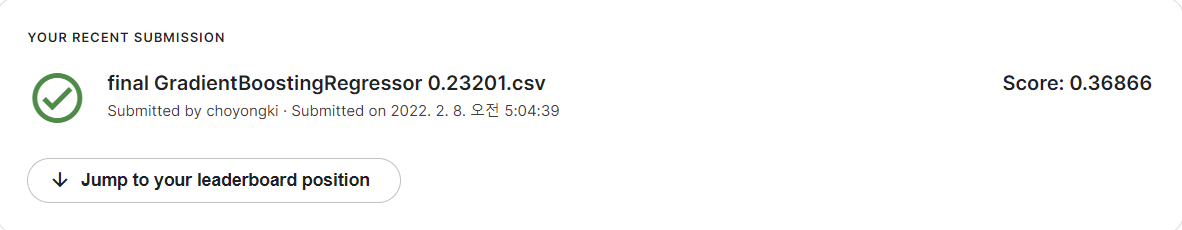

In [18]:
from IPython.display import Image
Image("./score.PNG")

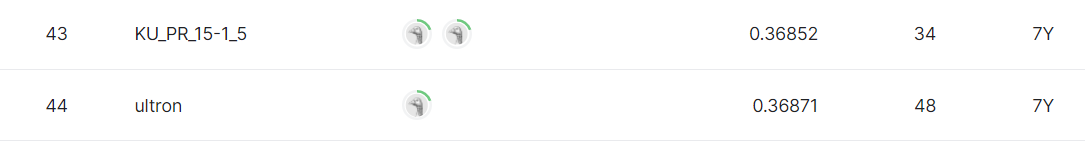

In [19]:
Image("./result.PNG")

# 최종 결과

1. 최고의 성능을 내는 모델 : GradientBoosting
    - 최적의 파라미터 값 :
        - n_estimators : 1490
    - 1.1 Score: 0.36866
    - 1.2 등수 : 44등 , 상위 1.3%
